In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA,FastICA
from sklearn.cluster import DBSCAN, KMeans
import umap
import lightgbm as lgb
%matplotlib inline
import matplotlib as plt
import matplotlib.style as stl
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pylab
plt.rcParams['figure.figsize'] = 16, 10
from os import cpu_count

In [2]:
pd.options.display.max_columns = None
n_jobs = max(cpu_count()-1, 1)

In [270]:
train_df = pd.read_csv('train.csv',sep='\t').drop('Unnamed: 0',axis=1)
test_df = pd.read_csv('test.csv',sep='\t').drop('Unnamed: 0',axis=1)

# Preprocessing

In [271]:
#9 is highly correlated with 2
correlated = ['9']
constant_values = ['5', '11', '129', '130', '137', '138', '141', '149', '150', '178', '186', '188', '192', '193', '291', '301', '303', '305','152', '160','140', '164']

#too_much_zeros_features = ['191', '182', '185', '181', '172', '170', '157', '136', '135']

In [272]:
train_df = train_df.drop(correlated,axis=1)
train_df = train_df.drop(constant_values,axis=1)
test_df = test_df.drop(correlated,axis=1)
test_df = test_df.drop(constant_values,axis=1)

In [273]:
test_df.shape

(4166, 323)

In [275]:
test_df.head()

,0,1,2,3,4,6,7,8,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,131,132,133,134,135,136,139,142,143,144,145,146,147,148,151,153,154,155,156,157,158,159,161,162,163,165,166,167,168,169,170,171,172,173,174,175,176,177,179,180,181,182,183,184,185,187,189,190,191,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,292,293,294,295,296,297,298,299,300,302,304,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345
0,NaN,1,0,0,1,0,0.136364,0,1,1,0.555556,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0.0,0.00000,0.0,0.0,0.35921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.89803,0.0,0.17961,0.17961,0.153846,0.028939,0.457598,1,1,1,1.000000,1.000000,0.389702,0.207745,0.046700,0.293568,0.133332,0.108743,0.30,0.304348,0.555556,0.052021,0.5,0.445127,0.844436,0.258310,0.120536,0.851549,0.308740,0.5,0.969052,0.997754,0.075269,0.044124,0.828099,0.014678,0.5,0.326132,0.916168,0.075269,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.044124,0.828099,0.207479,0.152690,0.175073,0.549325,0.478620,0.509881,0.292150,0.702982,0.237822,0.645717,0.338190,0.249612,0.754017,0.304419,0.888042,1.0,1.0,0.761512,0.153585,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.388995,0.842112,0.461724,0.446615,0.078764,0,0.071850,1,0.279886,0.429293,0.051663,0.638350,0.499279,0.116236,0.001895,0.268333,0.623211,0.480870,0.519130,0.199035,0.890508,1,0.077291,0.574936,0.134728,0.192984,0,1,0,0,0.222222,1,1,1,1
1,NaN,1,0,0,1,0,0.181818,0,1,1,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,1.0,0.00000,0.0,0.00000,0.00000,0.038462,0.014469,0.357848,0,1,1,0.135797,1.000000,1.000000,0.390839,0.160103,0.753314,0.097754,0.198160,0.35,0.130435,0.555556,0.011364,0.5,0.237096,0.812458,0.531814,0.151517,0.872622,0.017888,0.5,0.374784,0.926647,0.096774,0.038142,0.820386,0.308740,0.5,0.969052,0.997754,0.021505,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.018921,0.781267,0.107577,0.186750,0.179621,0.420534,0.431057,0.942957,0.057501,0.672653,0.267041,0.515884,0.161280,0.092513,0.697888,0.206254,0.867580,1.0,1.0,0.768640,0.040349,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.075937,0.572285,0.239612,1.000000,1.000000,0,0.096645,1,0.087719,0.376263,0.011455,0.456479,0.113528,0.099443,0.007252,0.418232,0.596438,0.254130,0.741635,0.091947,0.838127,0,0.082511,0.585569,0.042731,0.195690,0,1,0,0,0.000000,1,1,1,0
2,NaN,1,0,0,0,0,0.090909,0,1,1,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0,0.57735,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.57735,0.0,0.0,0.57735,0.0,0.00000,0.00000,0.115385,0.004823,0.215445

# Base model

In [6]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
X = train_df.drop(['0'], axis=1)
y = train_df['0']

In [772]:
parameters={
   'objective': 'binary',
    'learning_rate': 0.01,
    'max_depth': 8,
    'num_threads': 4,
    'metric': 'auc',
    'seed': 42,
    'colsample_bytree': 0.65,
    'subsample': 0.8,
    'subsample_freq': 2,
    'min_data_in_leaf': 15,
}
n_rounds = 10000

In [9]:
lgb_train = lgb.Dataset(X, label=y, free_raw_data=False)

In [10]:
result_base = lgb.cv(parameters, lgb_train, n_rounds, folds=skf.split(X, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.678943 + 0.00414656
[2]	cv_agg's auc: 0.691799 + 0.00885539
[3]	cv_agg's auc: 0.699423 + 0.00930007
[4]	cv_agg's auc: 0.705288 + 0.00752174
[5]	cv_agg's auc: 0.706464 + 0.00864524
[6]	cv_agg's auc: 0.70811 + 0.00701798
[7]	cv_agg's auc: 0.708472 + 0.00756751
[8]	cv_agg's auc: 0.709882 + 0.00786181
[9]	cv_agg's auc: 0.710649 + 0.00688371
[10]	cv_agg's auc: 0.710904 + 0.00661881
[11]	cv_agg's auc: 0.710834 + 0.00638842
[12]	cv_agg's auc: 0.710676 + 0.00615256
[13]	cv_agg's auc: 0.710921 + 0.00597416
[14]	cv_agg's auc: 0.710913 + 0.00600064
[15]	cv_agg's auc: 0.71076 + 0.00636688
[16]	cv_agg's auc: 0.710813 + 0.00675971
[17]	cv_agg's auc: 0.710831 + 0.00641083
[18]	cv_agg's auc: 0.711278 + 0.00649868
[19]	cv_agg's auc: 0.711492 + 0.00622084
[20]	cv_agg's auc: 0.711621 + 0.00583808
[21]	cv_agg's auc: 0.711569 + 0.00573416
[22]	cv_agg's auc: 0.712189 + 0.0056832
[23]	cv_agg's auc: 0.712196 + 0.00565143
[24]	cv_agg's auc: 0.71195 + 0.00554054
[25]	cv_agg's auc: 0.712087 +

[200]	cv_agg's auc: 0.729914 + 0.00528729
[201]	cv_agg's auc: 0.729959 + 0.0052274
[202]	cv_agg's auc: 0.729994 + 0.0052377
[203]	cv_agg's auc: 0.730061 + 0.0051952
[204]	cv_agg's auc: 0.730121 + 0.00517114
[205]	cv_agg's auc: 0.730207 + 0.00513997
[206]	cv_agg's auc: 0.73029 + 0.005194
[207]	cv_agg's auc: 0.730317 + 0.00516323
[208]	cv_agg's auc: 0.730384 + 0.0050836
[209]	cv_agg's auc: 0.730397 + 0.00512006
[210]	cv_agg's auc: 0.730447 + 0.00511987
[211]	cv_agg's auc: 0.730537 + 0.0051367
[212]	cv_agg's auc: 0.730671 + 0.00513893
[213]	cv_agg's auc: 0.730777 + 0.00511802
[214]	cv_agg's auc: 0.730925 + 0.0050895
[215]	cv_agg's auc: 0.73104 + 0.00511107
[216]	cv_agg's auc: 0.731168 + 0.00514245
[217]	cv_agg's auc: 0.731291 + 0.0051576
[218]	cv_agg's auc: 0.731437 + 0.00514138
[219]	cv_agg's auc: 0.731521 + 0.00514935
[220]	cv_agg's auc: 0.731596 + 0.00511187
[221]	cv_agg's auc: 0.73168 + 0.00516059
[222]	cv_agg's auc: 0.731796 + 0.00520714
[223]	cv_agg's auc: 0.731865 + 0.00526018
[224

[400]	cv_agg's auc: 0.74019 + 0.00601696
[401]	cv_agg's auc: 0.740196 + 0.00599507
[402]	cv_agg's auc: 0.74021 + 0.00598366
[403]	cv_agg's auc: 0.740222 + 0.00599678
[404]	cv_agg's auc: 0.740221 + 0.00606588
[405]	cv_agg's auc: 0.740264 + 0.00606578
[406]	cv_agg's auc: 0.740302 + 0.00607427
[407]	cv_agg's auc: 0.740327 + 0.00608929
[408]	cv_agg's auc: 0.740331 + 0.00607602
[409]	cv_agg's auc: 0.740353 + 0.00604269
[410]	cv_agg's auc: 0.740372 + 0.00604482
[411]	cv_agg's auc: 0.740377 + 0.00603633
[412]	cv_agg's auc: 0.740416 + 0.00602365
[413]	cv_agg's auc: 0.740422 + 0.00603471
[414]	cv_agg's auc: 0.74047 + 0.00601619
[415]	cv_agg's auc: 0.740499 + 0.0059924
[416]	cv_agg's auc: 0.740531 + 0.0060083
[417]	cv_agg's auc: 0.740559 + 0.00599365
[418]	cv_agg's auc: 0.740604 + 0.00599028
[419]	cv_agg's auc: 0.740613 + 0.00599272
[420]	cv_agg's auc: 0.74059 + 0.00596812
[421]	cv_agg's auc: 0.740624 + 0.00593429
[422]	cv_agg's auc: 0.740642 + 0.00592547
[423]	cv_agg's auc: 0.740667 + 0.0059069

[597]	cv_agg's auc: 0.744352 + 0.00577757
[598]	cv_agg's auc: 0.744378 + 0.00578039
[599]	cv_agg's auc: 0.744367 + 0.00575947
[600]	cv_agg's auc: 0.744412 + 0.00571082
[601]	cv_agg's auc: 0.744455 + 0.0057506
[602]	cv_agg's auc: 0.744474 + 0.0057172
[603]	cv_agg's auc: 0.74449 + 0.00573312
[604]	cv_agg's auc: 0.744509 + 0.00575296
[605]	cv_agg's auc: 0.744506 + 0.00578911
[606]	cv_agg's auc: 0.744552 + 0.00577781
[607]	cv_agg's auc: 0.744562 + 0.00578086
[608]	cv_agg's auc: 0.744564 + 0.00579106
[609]	cv_agg's auc: 0.744554 + 0.00580131
[610]	cv_agg's auc: 0.744577 + 0.00579368
[611]	cv_agg's auc: 0.744604 + 0.00583317
[612]	cv_agg's auc: 0.744631 + 0.00583064
[613]	cv_agg's auc: 0.744634 + 0.00582463
[614]	cv_agg's auc: 0.744635 + 0.00580601
[615]	cv_agg's auc: 0.744635 + 0.00580066
[616]	cv_agg's auc: 0.744668 + 0.00581085
[617]	cv_agg's auc: 0.744653 + 0.00578686
[618]	cv_agg's auc: 0.744637 + 0.00578878
[619]	cv_agg's auc: 0.744643 + 0.00579214
[620]	cv_agg's auc: 0.744687 + 0.0058

In [11]:
max(result_base['auc-mean']), len(result_base['auc-mean']) 

(0.7454628573901237, 716)

# 1. Dimensionality Reduction

### PCA

In [13]:
pca = PCA(n_components=250)

In [14]:
#pca.fit(X)

In [15]:
X_transform_pca = pca.fit_transform(X)

In [16]:
X.shape

(30500, 322)

In [17]:
X_transform_pca.shape

(30500, 250)

In [18]:
lgb_train_pca = lgb.Dataset(X_transform_pca, label=y, free_raw_data=False)

In [19]:
result_pca = lgb.cv(parameters, lgb_train_pca, n_rounds, folds=skf.split(X_transform_pca, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.619281 + 0.012692
[2]	cv_agg's auc: 0.663023 + 0.00821402
[3]	cv_agg's auc: 0.679521 + 0.00681948
[4]	cv_agg's auc: 0.687951 + 0.00766815
[5]	cv_agg's auc: 0.689274 + 0.00757241
[6]	cv_agg's auc: 0.692374 + 0.00877216
[7]	cv_agg's auc: 0.693639 + 0.00675645
[8]	cv_agg's auc: 0.695587 + 0.00642009
[9]	cv_agg's auc: 0.697503 + 0.0079983
[10]	cv_agg's auc: 0.698697 + 0.00746936
[11]	cv_agg's auc: 0.699519 + 0.00757893
[12]	cv_agg's auc: 0.70021 + 0.00740058
[13]	cv_agg's auc: 0.701043 + 0.0069817
[14]	cv_agg's auc: 0.70153 + 0.00727956
[15]	cv_agg's auc: 0.701785 + 0.00713832
[16]	cv_agg's auc: 0.701751 + 0.00705419
[17]	cv_agg's auc: 0.702382 + 0.00694194
[18]	cv_agg's auc: 0.702506 + 0.00673658
[19]	cv_agg's auc: 0.702929 + 0.00693884
[20]	cv_agg's auc: 0.703653 + 0.00762274
[21]	cv_agg's auc: 0.703592 + 0.00785723
[22]	cv_agg's auc: 0.703812 + 0.0077256
[23]	cv_agg's auc: 0.703868 + 0.00777244
[24]	cv_agg's auc: 0.704618 + 0.00790457
[25]	cv_agg's auc: 0.704933 + 0.

[201]	cv_agg's auc: 0.719562 + 0.00744468
[202]	cv_agg's auc: 0.719634 + 0.00749779
[203]	cv_agg's auc: 0.719691 + 0.00747664
[204]	cv_agg's auc: 0.719733 + 0.00749264
[205]	cv_agg's auc: 0.719779 + 0.00749532
[206]	cv_agg's auc: 0.719843 + 0.00743792
[207]	cv_agg's auc: 0.719894 + 0.00749146
[208]	cv_agg's auc: 0.719927 + 0.00747793
[209]	cv_agg's auc: 0.720047 + 0.00748312
[210]	cv_agg's auc: 0.720038 + 0.00747187
[211]	cv_agg's auc: 0.720138 + 0.00747617
[212]	cv_agg's auc: 0.720218 + 0.00744895
[213]	cv_agg's auc: 0.72025 + 0.00739369
[214]	cv_agg's auc: 0.720302 + 0.0073171
[215]	cv_agg's auc: 0.720389 + 0.00736458
[216]	cv_agg's auc: 0.720465 + 0.00733199
[217]	cv_agg's auc: 0.720584 + 0.00732354
[218]	cv_agg's auc: 0.720582 + 0.00733115
[219]	cv_agg's auc: 0.720824 + 0.00730979
[220]	cv_agg's auc: 0.720928 + 0.00735574
[221]	cv_agg's auc: 0.721016 + 0.00724668
[222]	cv_agg's auc: 0.721071 + 0.00725957
[223]	cv_agg's auc: 0.721095 + 0.00715798
[224]	cv_agg's auc: 0.721138 + 0.007

[397]	cv_agg's auc: 0.728853 + 0.00695111
[398]	cv_agg's auc: 0.728897 + 0.00694954
[399]	cv_agg's auc: 0.728956 + 0.00694382
[400]	cv_agg's auc: 0.728973 + 0.00696918
[401]	cv_agg's auc: 0.72897 + 0.00695077
[402]	cv_agg's auc: 0.72899 + 0.00690574
[403]	cv_agg's auc: 0.729057 + 0.00688665
[404]	cv_agg's auc: 0.7291 + 0.00691015
[405]	cv_agg's auc: 0.729187 + 0.0069059
[406]	cv_agg's auc: 0.729213 + 0.00695266
[407]	cv_agg's auc: 0.729214 + 0.00698511
[408]	cv_agg's auc: 0.729256 + 0.00697352
[409]	cv_agg's auc: 0.729303 + 0.00699252
[410]	cv_agg's auc: 0.72937 + 0.00693505
[411]	cv_agg's auc: 0.729397 + 0.00694481
[412]	cv_agg's auc: 0.729405 + 0.006996
[413]	cv_agg's auc: 0.729403 + 0.00697487
[414]	cv_agg's auc: 0.729458 + 0.00700924
[415]	cv_agg's auc: 0.729487 + 0.00704418
[416]	cv_agg's auc: 0.729548 + 0.00704111
[417]	cv_agg's auc: 0.729566 + 0.00705562
[418]	cv_agg's auc: 0.729597 + 0.00706932
[419]	cv_agg's auc: 0.729639 + 0.00707989
[420]	cv_agg's auc: 0.729631 + 0.00712004


[594]	cv_agg's auc: 0.732725 + 0.00736994
[595]	cv_agg's auc: 0.73274 + 0.00738379
[596]	cv_agg's auc: 0.732766 + 0.00740648
[597]	cv_agg's auc: 0.732764 + 0.0074163
[598]	cv_agg's auc: 0.732788 + 0.00741858
[599]	cv_agg's auc: 0.732814 + 0.00742149
[600]	cv_agg's auc: 0.732865 + 0.00742441
[601]	cv_agg's auc: 0.732855 + 0.00743166
[602]	cv_agg's auc: 0.732865 + 0.00740982
[603]	cv_agg's auc: 0.732888 + 0.00744146
[604]	cv_agg's auc: 0.7329 + 0.00745626
[605]	cv_agg's auc: 0.732938 + 0.00749213
[606]	cv_agg's auc: 0.732933 + 0.00749601
[607]	cv_agg's auc: 0.732975 + 0.00748045
[608]	cv_agg's auc: 0.73301 + 0.00747889
[609]	cv_agg's auc: 0.733023 + 0.00747931
[610]	cv_agg's auc: 0.733022 + 0.00748411
[611]	cv_agg's auc: 0.733005 + 0.00755405
[612]	cv_agg's auc: 0.733008 + 0.00757363
[613]	cv_agg's auc: 0.732988 + 0.00759373
[614]	cv_agg's auc: 0.733006 + 0.00760962
[615]	cv_agg's auc: 0.732966 + 0.00760818
[616]	cv_agg's auc: 0.73302 + 0.0075834
[617]	cv_agg's auc: 0.73303 + 0.00762432


In [20]:
max(result_pca['auc-mean']), len(result_pca['auc-mean'])

(0.7330900637623274, 629)

### FastICA

In [22]:
ica = FastICA(n_components=250)

In [23]:
ica.fit(X)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=250, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

In [24]:
X_transform_ica = ica.transform(X)

In [25]:
X.shape

(30500, 322)

In [26]:
X_transform_ica.shape

(30500, 250)

In [27]:
lgb_train_ica = lgb.Dataset(X_transform_ica, label=y, free_raw_data=False)

In [28]:
result_ica = lgb.cv(parameters, lgb_train_ica, n_rounds, folds=skf.split(X_transform_ica, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.641763 + 0.00582075
[2]	cv_agg's auc: 0.663552 + 0.00221736
[3]	cv_agg's auc: 0.67912 + 0.00438526
[4]	cv_agg's auc: 0.683556 + 0.00279912
[5]	cv_agg's auc: 0.686203 + 0.00390788
[6]	cv_agg's auc: 0.687597 + 0.00377034
[7]	cv_agg's auc: 0.68959 + 0.00427127
[8]	cv_agg's auc: 0.689828 + 0.00462037
[9]	cv_agg's auc: 0.691993 + 0.00499982
[10]	cv_agg's auc: 0.692098 + 0.00441045
[11]	cv_agg's auc: 0.692805 + 0.004422
[12]	cv_agg's auc: 0.692625 + 0.00483176
[13]	cv_agg's auc: 0.694352 + 0.00484633
[14]	cv_agg's auc: 0.695015 + 0.00503631
[15]	cv_agg's auc: 0.695175 + 0.00535774
[16]	cv_agg's auc: 0.696247 + 0.00490025
[17]	cv_agg's auc: 0.69711 + 0.00524189
[18]	cv_agg's auc: 0.698352 + 0.00504853
[19]	cv_agg's auc: 0.698509 + 0.00495302
[20]	cv_agg's auc: 0.698542 + 0.00460973
[21]	cv_agg's auc: 0.698721 + 0.00419337
[22]	cv_agg's auc: 0.69888 + 0.00440662
[23]	cv_agg's auc: 0.698764 + 0.00429516
[24]	cv_agg's auc: 0.699515 + 0.00352162
[25]	cv_agg's auc: 0.699353 + 0

[200]	cv_agg's auc: 0.719902 + 0.00590393
[201]	cv_agg's auc: 0.719894 + 0.00590901
[202]	cv_agg's auc: 0.71991 + 0.00591449
[203]	cv_agg's auc: 0.720008 + 0.00599139
[204]	cv_agg's auc: 0.720109 + 0.00598188
[205]	cv_agg's auc: 0.720203 + 0.00604552
[206]	cv_agg's auc: 0.72024 + 0.0060713
[207]	cv_agg's auc: 0.720333 + 0.00620651
[208]	cv_agg's auc: 0.720416 + 0.00626644
[209]	cv_agg's auc: 0.720433 + 0.006304
[210]	cv_agg's auc: 0.720538 + 0.0062727
[211]	cv_agg's auc: 0.720602 + 0.00632554
[212]	cv_agg's auc: 0.720711 + 0.00636285
[213]	cv_agg's auc: 0.720847 + 0.00641354
[214]	cv_agg's auc: 0.720875 + 0.006458
[215]	cv_agg's auc: 0.720942 + 0.00645367
[216]	cv_agg's auc: 0.721031 + 0.00650213
[217]	cv_agg's auc: 0.721233 + 0.00646229
[218]	cv_agg's auc: 0.721389 + 0.00641819
[219]	cv_agg's auc: 0.721453 + 0.00640826
[220]	cv_agg's auc: 0.721534 + 0.00637252
[221]	cv_agg's auc: 0.721588 + 0.00642368
[222]	cv_agg's auc: 0.721683 + 0.00647672
[223]	cv_agg's auc: 0.721838 + 0.00651244


[398]	cv_agg's auc: 0.731203 + 0.00764957
[399]	cv_agg's auc: 0.731268 + 0.00766455
[400]	cv_agg's auc: 0.731271 + 0.00762857
[401]	cv_agg's auc: 0.731254 + 0.00757671
[402]	cv_agg's auc: 0.731298 + 0.00755219
[403]	cv_agg's auc: 0.731375 + 0.00752097
[404]	cv_agg's auc: 0.731398 + 0.00749938
[405]	cv_agg's auc: 0.731411 + 0.00747034
[406]	cv_agg's auc: 0.731453 + 0.00745163
[407]	cv_agg's auc: 0.731519 + 0.00750134
[408]	cv_agg's auc: 0.731558 + 0.00751138
[409]	cv_agg's auc: 0.731551 + 0.00756133
[410]	cv_agg's auc: 0.731555 + 0.00754848
[411]	cv_agg's auc: 0.731629 + 0.00752361
[412]	cv_agg's auc: 0.731705 + 0.00761136
[413]	cv_agg's auc: 0.731749 + 0.00762773
[414]	cv_agg's auc: 0.731779 + 0.0076228
[415]	cv_agg's auc: 0.731819 + 0.00758023
[416]	cv_agg's auc: 0.731777 + 0.00755768
[417]	cv_agg's auc: 0.731835 + 0.00753508
[418]	cv_agg's auc: 0.731884 + 0.00749709
[419]	cv_agg's auc: 0.731877 + 0.00746198
[420]	cv_agg's auc: 0.73192 + 0.00747206
[421]	cv_agg's auc: 0.731959 + 0.007

In [34]:
max(result_ica['auc-mean']), len(result_ica['auc-mean'])

(0.7331995690307264, 502)

### t-SNE


In [317]:
from sklearn.manifold import TSNE

In [454]:
tsne = TSNE(n_components=2,verbose=1, 
            perplexity=30, 
            n_iter=300)

In [455]:
X_transform_tsne = tsne.fit_transform(X,y)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30500 samples in 7.675s...
[t-SNE] Computed neighbors for 30500 samples in 582.524s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30500
[t-SNE] Computed conditional probabilities for sample 2000 / 30500
[t-SNE] Computed conditional probabilities for sample 3000 / 30500
[t-SNE] Computed conditional probabilities for sample 4000 / 30500
[t-SNE] Computed conditional probabilities for sample 5000 / 30500
[t-SNE] Computed conditional probabilities for sample 6000 / 30500
[t-SNE] Computed conditional probabilities for sample 7000 / 30500
[t-SNE] Computed conditional probabilities for sample 8000 / 30500
[t-SNE] Computed conditional probabilities for sample 9000 / 30500
[t-SNE] Computed conditional probabilities for sample 10000 / 30500
[t-SNE] Computed conditional probabilities for sample 11000 / 30500
[t-SNE] Computed conditional probabilities for sample 12000 / 30500
[t-SNE] Computed conditional probabilities for s

In [456]:
lgb_train_tsne = lgb.Dataset(X_transform_tsne, label=y, free_raw_data=False)

In [457]:
result = lgb.cv(parameters, lgb_train_tsne, n_rounds, folds=skf.split(X_transform_tsne, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.612656 + 0.00578016
[2]	cv_agg's auc: 0.647417 + 0.00598347
[3]	cv_agg's auc: 0.642645 + 0.00621249
[4]	cv_agg's auc: 0.649228 + 0.00648029
[5]	cv_agg's auc: 0.646888 + 0.00654759
[6]	cv_agg's auc: 0.649887 + 0.00630439
[7]	cv_agg's auc: 0.648386 + 0.00673152
[8]	cv_agg's auc: 0.650151 + 0.00672552
[9]	cv_agg's auc: 0.649026 + 0.00729178
[10]	cv_agg's auc: 0.650367 + 0.00685086
[11]	cv_agg's auc: 0.649412 + 0.00701377
[12]	cv_agg's auc: 0.650479 + 0.00660476
[13]	cv_agg's auc: 0.649687 + 0.00674044
[14]	cv_agg's auc: 0.650531 + 0.00665315
[15]	cv_agg's auc: 0.650089 + 0.00666992
[16]	cv_agg's auc: 0.650871 + 0.00650621
[17]	cv_agg's auc: 0.650401 + 0.00670943
[18]	cv_agg's auc: 0.650853 + 0.00652257
[19]	cv_agg's auc: 0.650293 + 0.00668392
[20]	cv_agg's auc: 0.650809 + 0.00662801
[21]	cv_agg's auc: 0.650572 + 0.00666646
[22]	cv_agg's auc: 0.651007 + 0.00665642
[23]	cv_agg's auc: 0.650605 + 0.00660748
[24]	cv_agg's auc: 0.651152 + 0.00644255
[25]	cv_agg's auc: 0.6509

[209]	cv_agg's auc: 0.655728 + 0.0056751
[210]	cv_agg's auc: 0.655762 + 0.00566916
[211]	cv_agg's auc: 0.655772 + 0.00563347
[212]	cv_agg's auc: 0.65583 + 0.00564536
[213]	cv_agg's auc: 0.655777 + 0.00562367
[214]	cv_agg's auc: 0.655813 + 0.00562662
[215]	cv_agg's auc: 0.655821 + 0.00562541
[216]	cv_agg's auc: 0.655848 + 0.00563739
[217]	cv_agg's auc: 0.655836 + 0.005628
[218]	cv_agg's auc: 0.655872 + 0.00564927
[219]	cv_agg's auc: 0.655839 + 0.00561601
[220]	cv_agg's auc: 0.655874 + 0.00563178
[221]	cv_agg's auc: 0.655907 + 0.0056263
[222]	cv_agg's auc: 0.655939 + 0.00564879
[223]	cv_agg's auc: 0.655941 + 0.00564954
[224]	cv_agg's auc: 0.655995 + 0.00567463
[225]	cv_agg's auc: 0.655986 + 0.00567707
[226]	cv_agg's auc: 0.656023 + 0.00566579
[227]	cv_agg's auc: 0.656027 + 0.00566308
[228]	cv_agg's auc: 0.656054 + 0.00565045
[229]	cv_agg's auc: 0.656069 + 0.00563081
[230]	cv_agg's auc: 0.656103 + 0.00563941
[231]	cv_agg's auc: 0.656109 + 0.0056512
[232]	cv_agg's auc: 0.656171 + 0.005652


[414]	cv_agg's auc: 0.658356 + 0.00573331
[415]	cv_agg's auc: 0.658353 + 0.00571823
[416]	cv_agg's auc: 0.658379 + 0.00572819
[417]	cv_agg's auc: 0.658373 + 0.00571295
[418]	cv_agg's auc: 0.658368 + 0.00570673
[419]	cv_agg's auc: 0.658363 + 0.0056988
[420]	cv_agg's auc: 0.658366 + 0.00570618
[421]	cv_agg's auc: 0.658369 + 0.00568033
[422]	cv_agg's auc: 0.658364 + 0.00567951
[423]	cv_agg's auc: 0.65835 + 0.00567142
[424]	cv_agg's auc: 0.658355 + 0.00567064
[425]	cv_agg's auc: 0.658369 + 0.00567888
[426]	cv_agg's auc: 0.658354 + 0.00566762


In [458]:
max(result['auc-mean']), len(result['auc-mean'])

(0.6583792828846702, 416)

### umap

In [32]:
X_transform_umap = umap.UMAP(n_neighbors=22,
                 min_dist=0.01,
                 metric='correlation').fit_transform(X)


In [36]:
lgb_train_umap = lgb.Dataset(X_transform_umap, label=y, free_raw_data=False)

In [37]:
result = lgb.cv(parameters, lgb_train_umap, n_rounds, folds=skf.split(X_transform_umap, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.640654 + 0.00896751
[2]	cv_agg's auc: 0.658887 + 0.00688516
[3]	cv_agg's auc: 0.657677 + 0.00719954
[4]	cv_agg's auc: 0.659772 + 0.00727475
[5]	cv_agg's auc: 0.65974 + 0.00777636
[6]	cv_agg's auc: 0.660195 + 0.00722512
[7]	cv_agg's auc: 0.66016 + 0.00779943
[8]	cv_agg's auc: 0.660375 + 0.00744137
[9]	cv_agg's auc: 0.660066 + 0.00766948
[10]	cv_agg's auc: 0.660492 + 0.007533
[11]	cv_agg's auc: 0.660251 + 0.00772417
[12]	cv_agg's auc: 0.660407 + 0.00740823
[13]	cv_agg's auc: 0.660436 + 0.00766601
[14]	cv_agg's auc: 0.660428 + 0.00748977
[15]	cv_agg's auc: 0.660381 + 0.00762957
[16]	cv_agg's auc: 0.660466 + 0.00742001
[17]	cv_agg's auc: 0.660445 + 0.00764562
[18]	cv_agg's auc: 0.66057 + 0.00752231
[19]	cv_agg's auc: 0.660524 + 0.00761318
[20]	cv_agg's auc: 0.660578 + 0.00750638
[21]	cv_agg's auc: 0.660433 + 0.00760672
[22]	cv_agg's auc: 0.660405 + 0.00741161
[23]	cv_agg's auc: 0.660416 + 0.00732713
[24]	cv_agg's auc: 0.660471 + 0.00727358
[25]	cv_agg's auc: 0.660486 + 

# 2. Clastering

"Based on your setup (dataset size, data distribution etc.) 
you should start with simplier approaches (say, PCA + K-means) and 
(if possible) finish with something tricky like UMAP / TSNE + DBSCAN / HDBSCAN"

In [53]:
X_test = test_df.drop(['0'], axis=1)

In [54]:
X_with_target = X.copy() 
X_with_target['target'] = y
new_df = pd.concat([X_with_target, X_test], axis=0)
# add column for filtering train/test
new_df['is_train'] = True
new_df.loc[df['target'].isnull(), 'is_train'] = False

In [55]:
new_df.head()

,1,10,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,128,13,131,132,133,134,135,136,139,14,142,143,144,145,146,147,148,15,151,153,154,155,156,157,158,159,16,161,162,163,165,166,167,168,169,17,170,171,172,173,174,175,176,177,179,18,180,181,182,183,184,185,187,189,19,190,191,194,195,196,197,198,199,2,20,200,201,202,203,204,205,206,207,208,209,21,210,211,212,213,214,215,216,217,218,219,22,220,221,222,223,224,225,226,227,228,229,23,230,231,232,233,234,235,236,237,238,239,24,240,241,242,243,244,245,246,247,248,249,25,250,251,252,253,254,255,256,257,258,259,26,260,261,262,263,264,265,266,267,268,269,27,270,271,272,273,274,275,276,277,278,279,28,280,281,282,283,284,285,286,287,288,289,29,290,292,293,294,295,296,297,298,299,3,30,300,302,304,306,307,308,309,31,310,311,312,313,314,315,316,317,318,319,32,320,321,322,323,324,325,326,327,328,329,33,330,331,332,333,334,335,336,337,338,339,34,340,341,342,343,344,345,35,36,37,38,39,4,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,6,60,61,62,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,target,is_train
0,1,1,0.352568,0.089094,0.011460,0.823985,0.063204,0.062223,0.35,0.173913,0.555556,0.075643,0.519230,0.293616,0.853005,0.315582,0.100401,0.837033,0.308740,0.75,0.969052,0.997754,1,0.064516,0.038252,0.820386,0.000000,0.50,0.000020,0.197605,0.021505,0,0.461538,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.028976,0.804959,0.256315,0.233609,0.207241,0.543609,0,0,0.636277,0.674055,0.411088,0.681005,0.492990,0.676865,0.510106,0.273482,0.666876,0.271396,0,0.743387,1.000000,1.0,0.761512,0.137851,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.130447,0.660812,0.150456,0.583333,0.341582,0,0.093772,1,0.332109,0,0.419192,0.062752,0.662008,0.181560,0.347370,0.004595,0.366032,0.813739,0.216998,0.783002,0,0.263109,0.909438,1,0.297790,0.797473,0.178935,0.221395,0,1,0,1,0,0.222222,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0.0,0.00000,0.0,0.0,0.090909,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0000,0.00000,0.0,0.0,0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.80904,0.00000,0.13484,0.40452,0.00000,0.40452,0.153846,0.020900,0.410139,1,1,1,0.936569,0.322213,1.0,True
1,1,1,0.352568,0.102546,0.036168,0.823985,0.072747,0.171335,0.25,0.217391,0.722222,0.103864,0.593750,0.073648,0.612603,0.222222,0.025549,0.737636,0.347640,1.00,0.341784,0.919910,1,0.064516,0.016164,0.773003,0.066100,0.50,0.067294,0.797904,0.053763,0,0.187500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.008943,0.740496,0.374360,0.171766,0.222209,0.707014,0,0,0.626137,0.644117,0.469494,0.668941,0.541728,0.716629,0.546316,0.482135,0.673065,0.381908,0,0.628642,1.000000,1.0,0.761512,0.107644,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.084065,0.588824,0.065451,0.488932,0.448880,0,0.093083,1,0.189719,0,0.310606,0.017096,0.504464,0.103531,0.256125,0.012358,0.480100,0.760360,0.280813,0.719187,0,0.252015,0.906516,0,0.207799,0.737641,0.110012,0.241508,0,1,0,0,0,0.111111,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0.0,0.00000,0.0,0.0,0.090909,0.0,0.46291,0.00000,0.15430,0.0,0.0,0.1543,0.00000,0.0,0.0,0,0.0,0.0,0.46291,0.46291,0.30861,0.0,0.46291,0.00000,0.00000,0.00000,0.00000,0.00000,0.269231,0.025723,0.440312,1,1,1,0.558273,0.322213,1.0,True
2,1,1,0.146644,0.000756,0.000024,1.000000,0.001289,0.015625,0.20,0.086957,0.611111,0.083598,0.575000,0.110840,0.690868,0.252991,0.041802,0.796249,0.395747,0.75,0.339980,0.919162,1,

# k_means and pca

In [56]:
pca_k_means = PCA(n_components=2)

In [57]:
new_df.columns[:-2]

Index(['1', '10', '100', '101', '102', '103', '104', '105', '106', '107',
       ...
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'],
      dtype='object', length=322)

In [58]:
df_pca = pca_k_means.fit_transform(new_df[new_df.columns[:-2]])

In [59]:
km = KMeans(n_clusters=4, n_jobs=n_jobs)

In [60]:
clustered_labels_km = km.fit_predict(df_pca)

In [61]:
clustered_labels_km

array([0, 0, 0, ..., 1, 1, 2])

In [63]:
np.unique(clustered_labels_km)

array([0, 1, 2, 3])

In [64]:
np.unique(clustered_labels_km).shape[0]

4

In [65]:
pd.Series(clustered_labels_km).value_counts()

0    14871
1    12509
3     4140
2     3146
dtype: int64

In [73]:
df_pca[:,0]

array([ 0.81280836,  1.19658084,  1.30844712, ..., -1.83537744,
       -1.78734817, -0.44934139])

In [79]:
df_pca[:,1]

array([ 1.01336496,  0.17712113,  0.16685706, ...,  0.59853764,
        0.02120492, -0.90735386])

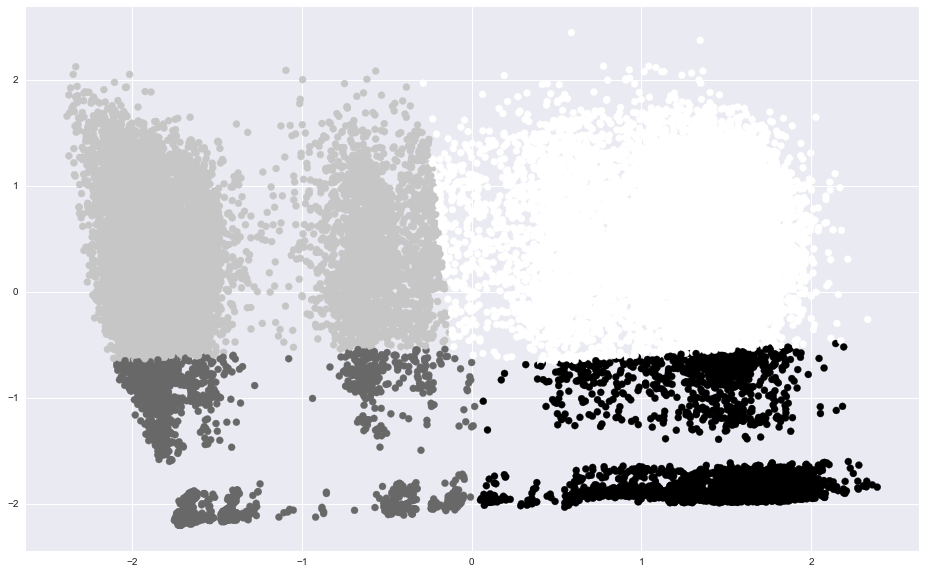

In [98]:
plt.pyplot.scatter(df_pca[:,0], df_pca[:,1], c=clustered_labels_km)


In [99]:
new_df['pca+kmeans'] = clustered_labels_km

In [100]:
X_train_km = df.loc[df.is_train]
X_test_km = df.loc[df.is_train == False]

In [103]:
X_train_km.tail()

,1,10,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,128,13,131,132,133,134,135,136,139,14,142,143,144,145,146,147,148,15,151,153,154,155,156,157,158,159,16,161,162,163,165,166,167,168,169,17,170,171,172,173,174,175,176,177,179,18,180,181,182,183,184,185,187,189,19,190,191,194,195,196,197,198,199,2,20,200,201,202,203,204,205,206,207,208,209,21,210,211,212,213,214,215,216,217,218,219,22,220,221,222,223,224,225,226,227,228,229,23,230,231,232,233,234,235,236,237,238,239,24,240,241,242,243,244,245,246,247,248,249,25,250,251,252,253,254,255,256,257,258,259,26,260,261,262,263,264,265,266,267,268,269,27,270,271,272,273,274,275,276,277,278,279,28,280,281,282,283,284,285,286,287,288,289,29,290,292,293,294,295,296,297,298,299,3,30,300,302,304,306,307,308,309,31,310,311,312,313,314,315,316,317,318,319,32,320,321,322,323,324,325,326,327,328,329,33,330,331,332,333,334,335,336,337,338,339,34,340,341,342,343,344,345,35,36,37,38,39,4,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,6,60,61,62,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,target,is_train
30495,1,1,0.089138,0.310530,0.126254,0.888868,0.871319,0.196722,0.40,0.304348,0.444444,0.022528,0.5,0.503075,0.949102,0.615385,0.250856,0.916515,0.022528,0.5,0.503075,0.949102,1,0.096774,0.049495,0.834711,0.019834,0.5,0.442270,0.939371,0.021505,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.020696,0.786226,0.316665,0.370712,0.513644,0.461111,0,0,0.686579,0.270851,0.263962,1.000000,0.239716,0.722645,0.441629,0.065392,0.868829,0.303396,0,0.877532,1.000000,1.000000,0.528906,0.304619,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.031556,0.432451,0.347293,0.235026,0.590108,0,0.115465,1,0.886577,0,1.000000,0.000175,0.059220,0.431082,0.424557,0.778700,0.970290,0.848982,0.000000,1.000000,0,0.000000,0.000000,1,0.430418,0.858922,0.276931,0.109160,1,0,0,0,0,0.0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000,0.00000,0.0,0.0,0.038462,0.003215,0.170736,1,1,1,0.151094,0.075385,0.0,True
30496,1,1,0.352568,0.089094,0.040110,0.823985,0.063204,0.217779,0.30,0.217391,0.500000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1,0.000000,0.000000,0.000000,0.111766,0.5,0.180193,0.872006,0.032258,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.008744,0.738843,0.302739,0.308336,0.251577,0.486121,0,0,0.669765,0.728034,0.374239,0.691665,0.502599,0.509391,0.496008,0.407630,0.674485,0.347966,0,0.681187,1.000000,1.000000,1.000000,1.000000,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.075937,0.572285,0.239612,1.000000,1.000000,0,0.108566,1,1.000000,0,0.449495,0.000550,0.132759,0.744490,1.000000,1.000000,1.000000,1.000000,0.017365,0.982634,0,0.060094,0.809281,1,1.000000,1.000000,1.000000,0.450414,1,0,0,0,0,0.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0,1,1,0.563204,0.322213,0.0,True
30497,1,1,1.000000,1.000000,0.057568,0.753314,0.250112,0.027848,0.20,0.173913,0.666667,0.143069,0.5,0.450169,0.910180,0.319089,0.079397,0.840290,0.308740,0.5,0.969052,0.997754,1,0.096774,0.021000,0.787328,0.089659,0.5,0.281079,0.904940,0.032258,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0

In [104]:
X_test_km.head()

,1,10,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,128,13,131,132,133,134,135,136,139,14,142,143,144,145,146,147,148,15,151,153,154,155,156,157,158,159,16,161,162,163,165,166,167,168,169,17,170,171,172,173,174,175,176,177,179,18,180,181,182,183,184,185,187,189,19,190,191,194,195,196,197,198,199,2,20,200,201,202,203,204,205,206,207,208,209,21,210,211,212,213,214,215,216,217,218,219,22,220,221,222,223,224,225,226,227,228,229,23,230,231,232,233,234,235,236,237,238,239,24,240,241,242,243,244,245,246,247,248,249,25,250,251,252,253,254,255,256,257,258,259,26,260,261,262,263,264,265,266,267,268,269,27,270,271,272,273,274,275,276,277,278,279,28,280,281,282,283,284,285,286,287,288,289,29,290,292,293,294,295,296,297,298,299,3,30,300,302,304,306,307,308,309,31,310,311,312,313,314,315,316,317,318,319,32,320,321,322,323,324,325,326,327,328,329,33,330,331,332,333,334,335,336,337,338,339,34,340,341,342,343,344,345,35,36,37,38,39,4,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,6,60,61,62,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,target,is_train
0,1,1,0.389702,0.207745,0.046700,0.293568,0.133332,0.108743,0.30,0.304348,0.555556,0.052021,0.5,0.445127,0.844436,0.258310,0.120536,0.851549,0.308740,0.5,0.969052,0.997754,1,0.075269,0.044124,0.828099,0.014678,0.5,0.326132,0.916168,0.075269,0,0.555556,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.044124,0.828099,0.207479,0.152690,0.175073,0.549325,0,0,0.478620,0.509881,0.292150,0.702982,0.237822,0.645717,0.338190,0.249612,0.754017,0.304419,0,0.888042,1.0,1.0,0.761512,0.153585,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.388995,0.842112,0.461724,0.446615,0.078764,0,0.071850,1,0.279886,0,0.429293,0.051663,0.638350,0.499279,0.116236,0.001895,0.268333,0.623211,0.480870,0.519130,0,0.199035,0.890508,1,0.077291,0.574936,0.134728,0.192984,0,1,0,0,0,0.222222,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0.0,0.00000,0.0,0.0,0.136364,0.35921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.89803,0.0,0.17961,0.17961,0.153846,0.028939,0.457598,1,1,1,1.000000,1.000000,NaN,False
1,1,1,1.000000,0.390839,0.160103,0.753314,0.097754,0.198160,0.35,0.130435,0.555556,0.011364,0.5,0.237096,0.812458,0.531814,0.151517,0.872622,0.017888,0.5,0.374784,0.926647,1,0.096774,0.038142,0.820386,0.308740,0.5,0.969052,0.997754,0.021505,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.018921,0.781267,0.107577,0.186750,0.179621,0.420534,0,0,0.431057,0.942957,0.057501,0.672653,0.267041,0.515884,0.161280,0.092513,0.697888,0.206254,0,0.867580,1.0,1.0,0.768640,0.040349,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.075937,0.572285,0.239612,1.000000,1.000000,0,0.096645,1,0.087719,0,0.376263,0.011455,0.456479,0.113528,0.099443,0.007252,0.418232,0.596438,0.254130,0.741635,0,0.091947,0.838127,0,0.082511,0.585569,0.042731,0.195690,0,1,0,0,0,0.000000,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0.00000,0.0,0.0,0.181818,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,1.0,0.00000,0.0,0.00000,0.00000,0.038462,0.014469,0.357848,0,1,1,0.135797,1.000000,NaN,False
2,1,1,0.003507,0.001145,0.000226,0.063283,0.081684,0.095361,0.30,0.130435,0.555556,0.025958,0.5,0.185889,0.800399,0.433048,0.096462,0.810446,0.037353,0.5,0.503075,0.949102,1,0.096774,0.049495,0.834711,0.000042,0.5,0.000042,0.249251,0.010753,0,0.000000,0,0,0,0,0,0,0,0,0,0,

In [105]:
lgb_train_km = lgb.Dataset(X_train_km.drop(['target', 'is_train'], axis=1), label=y, free_raw_data=False)

In [106]:
result_lgb_km = lgb.cv(parameters, lgb_train_km, n_rounds, folds=skf.split(X_train_km, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.676479 + 0.00702309
[2]	cv_agg's auc: 0.688973 + 0.00349094
[3]	cv_agg's auc: 0.698242 + 0.00465322
[4]	cv_agg's auc: 0.700176 + 0.00601274
[5]	cv_agg's auc: 0.703513 + 0.00737215
[6]	cv_agg's auc: 0.704807 + 0.00728201
[7]	cv_agg's auc: 0.70673 + 0.00770952
[8]	cv_agg's auc: 0.707146 + 0.00817458
[9]	cv_agg's auc: 0.707178 + 0.00839891
[10]	cv_agg's auc: 0.707532 + 0.00812406
[11]	cv_agg's auc: 0.708546 + 0.00757388
[12]	cv_agg's auc: 0.709323 + 0.00723347
[13]	cv_agg's auc: 0.710024 + 0.00619317
[14]	cv_agg's auc: 0.709928 + 0.0055426
[15]	cv_agg's auc: 0.709239 + 0.0057482
[16]	cv_agg's auc: 0.70879 + 0.00562107
[17]	cv_agg's auc: 0.709323 + 0.00556242
[18]	cv_agg's auc: 0.710329 + 0.00543624
[19]	cv_agg's auc: 0.710381 + 0.00539009
[20]	cv_agg's auc: 0.710671 + 0.00566522
[21]	cv_agg's auc: 0.710553 + 0.00576253
[22]	cv_agg's auc: 0.711401 + 0.00559863
[23]	cv_agg's auc: 0.711618 + 0.00532376
[24]	cv_agg's auc: 0.711773 + 0.00530651
[25]	cv_agg's auc: 0.712072 +

[200]	cv_agg's auc: 0.729902 + 0.00615075
[201]	cv_agg's auc: 0.730011 + 0.00618948
[202]	cv_agg's auc: 0.730046 + 0.00622497
[203]	cv_agg's auc: 0.730142 + 0.00616599
[204]	cv_agg's auc: 0.730144 + 0.00613309
[205]	cv_agg's auc: 0.730181 + 0.0061244
[206]	cv_agg's auc: 0.730295 + 0.00612378
[207]	cv_agg's auc: 0.730317 + 0.00608722
[208]	cv_agg's auc: 0.730429 + 0.00609067
[209]	cv_agg's auc: 0.730457 + 0.00610061
[210]	cv_agg's auc: 0.730522 + 0.00609493
[211]	cv_agg's auc: 0.730618 + 0.00610178
[212]	cv_agg's auc: 0.730687 + 0.00609308
[213]	cv_agg's auc: 0.730829 + 0.00606636
[214]	cv_agg's auc: 0.730943 + 0.00605284
[215]	cv_agg's auc: 0.731072 + 0.00601229
[216]	cv_agg's auc: 0.731157 + 0.00597409
[217]	cv_agg's auc: 0.731287 + 0.00598805
[218]	cv_agg's auc: 0.731393 + 0.00600295
[219]	cv_agg's auc: 0.731533 + 0.00607011
[220]	cv_agg's auc: 0.731589 + 0.00607013
[221]	cv_agg's auc: 0.731664 + 0.00610323
[222]	cv_agg's auc: 0.731655 + 0.00611672
[223]	cv_agg's auc: 0.731752 + 0.00

[401]	cv_agg's auc: 0.740419 + 0.0064883
[402]	cv_agg's auc: 0.740453 + 0.00644895
[403]	cv_agg's auc: 0.740453 + 0.00641911
[404]	cv_agg's auc: 0.740433 + 0.00639937
[405]	cv_agg's auc: 0.740445 + 0.00639543
[406]	cv_agg's auc: 0.740495 + 0.00640594
[407]	cv_agg's auc: 0.740572 + 0.00641625
[408]	cv_agg's auc: 0.740602 + 0.00638804
[409]	cv_agg's auc: 0.740631 + 0.00638711
[410]	cv_agg's auc: 0.740666 + 0.00635749
[411]	cv_agg's auc: 0.74071 + 0.00635277
[412]	cv_agg's auc: 0.740764 + 0.00635861
[413]	cv_agg's auc: 0.740755 + 0.00638151
[414]	cv_agg's auc: 0.740783 + 0.00635496
[415]	cv_agg's auc: 0.740797 + 0.00634162
[416]	cv_agg's auc: 0.74083 + 0.00635497
[417]	cv_agg's auc: 0.740865 + 0.00634026
[418]	cv_agg's auc: 0.740904 + 0.00636933
[419]	cv_agg's auc: 0.740901 + 0.00635397
[420]	cv_agg's auc: 0.740932 + 0.00634484
[421]	cv_agg's auc: 0.740922 + 0.00634773
[422]	cv_agg's auc: 0.74095 + 0.00636487
[423]	cv_agg's auc: 0.740966 + 0.00634722
[424]	cv_agg's auc: 0.740976 + 0.00631

[599]	cv_agg's auc: 0.74422 + 0.00624099
[600]	cv_agg's auc: 0.744246 + 0.00625286
[601]	cv_agg's auc: 0.744257 + 0.0062539
[602]	cv_agg's auc: 0.744279 + 0.00625658
[603]	cv_agg's auc: 0.744318 + 0.00627794
[604]	cv_agg's auc: 0.744337 + 0.00628732
[605]	cv_agg's auc: 0.744326 + 0.00627121
[606]	cv_agg's auc: 0.744335 + 0.00626731
[607]	cv_agg's auc: 0.744319 + 0.00628841
[608]	cv_agg's auc: 0.744321 + 0.00626566
[609]	cv_agg's auc: 0.744331 + 0.00625339
[610]	cv_agg's auc: 0.744341 + 0.00625337
[611]	cv_agg's auc: 0.74437 + 0.00626843
[612]	cv_agg's auc: 0.744397 + 0.00629564
[613]	cv_agg's auc: 0.744413 + 0.00629394
[614]	cv_agg's auc: 0.744412 + 0.00627862
[615]	cv_agg's auc: 0.744463 + 0.00625372
[616]	cv_agg's auc: 0.744484 + 0.00624806
[617]	cv_agg's auc: 0.744516 + 0.00629196
[618]	cv_agg's auc: 0.744519 + 0.00630715
[619]	cv_agg's auc: 0.74452 + 0.00631674
[620]	cv_agg's auc: 0.744512 + 0.00634407
[621]	cv_agg's auc: 0.744514 + 0.00632757
[622]	cv_agg's auc: 0.744499 + 0.00632

In [107]:
max(result_lgb_km['auc-mean']), len(result_lgb_km['auc-mean'])

(0.7458790586032003, 763)

In [109]:
#0.0004162012130765058

# dbscan and umap


In [395]:
X_test = test_df.drop(['0'], axis=1)

In [396]:
X_with_target = X.copy() 
X_with_target['target'] = y
new_df = pd.concat([X_with_target, X_test], axis=0)
# add column for filtering train/test
new_df['is_train'] = True
new_df.loc[df['target'].isnull(), 'is_train'] = False

In [397]:
ump = umap.UMAP(n_neighbors=22,
                 min_dist=0.01,
                 metric='correlation')

In [398]:
df_ump=ump.fit_transform(new_df[new_df.columns[:-2]])

eps - The maximum distance between two samples for them to be considered as in the same neighborhood.

min_samples - The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

In [399]:
dbscan = DBSCAN(
    eps=1,
    min_samples=30,
    n_jobs=n_jobs,
)

In [400]:
clustered_labels_dbscan = dbscan.fit_predict(df_ump)

In [401]:
np.unique(clustered_labels_dbscan).shape[0]

7

In [402]:
pd.Series(clustered_labels_dbscan).value_counts()

0    14831
1    10561
3     3450
5     2039
2     1469
6     1362
4      954
dtype: int64

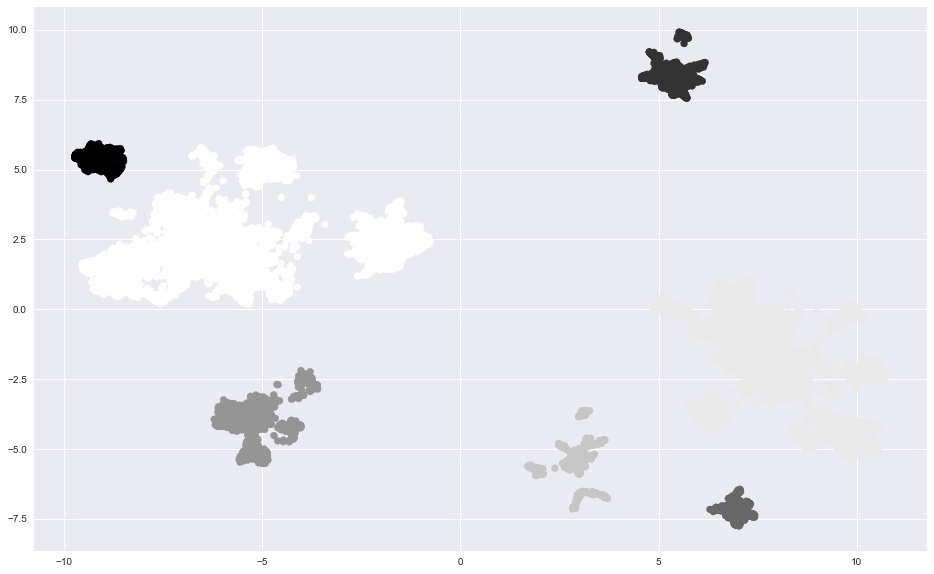

In [403]:
plt.pyplot.scatter(df_ump[:,0], df_ump[:,1], c=clustered_labels_dbscan)

In [404]:
new_df['dbscan+umap'] = clustered_labels_dbscan
X_train_dbscan = new_df.loc[new_df.is_train]
X_test_dbscan = new_df.loc[new_df.is_train == False]

In [405]:
new_df.head()

,1,10,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,128,13,131,132,133,134,135,136,139,14,142,143,144,145,146,147,148,15,151,153,154,155,156,157,158,159,16,161,162,163,165,166,167,168,169,17,170,171,172,173,174,175,176,177,179,18,180,181,182,183,184,185,187,189,19,190,191,194,195,196,197,198,199,2,20,200,201,202,203,204,205,206,207,208,209,21,210,211,212,213,214,215,216,217,218,219,22,220,221,222,223,224,225,226,227,228,229,23,230,231,232,233,234,235,236,237,238,239,24,240,241,242,243,244,245,246,247,248,249,25,250,251,252,253,254,255,256,257,258,259,26,260,261,262,263,264,265,266,267,268,269,27,270,271,272,273,274,275,276,277,278,279,28,280,281,282,283,284,285,286,287,288,289,29,290,292,293,294,295,296,297,298,299,3,30,300,302,304,306,307,308,309,31,310,311,312,313,314,315,316,317,318,319,32,320,321,322,323,324,325,326,327,328,329,33,330,331,332,333,334,335,336,337,338,339,34,340,341,342,343,344,345,35,36,37,38,39,4,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,6,60,61,62,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,target,is_train,dbscan+umap
0,1,1,0.352568,0.089094,0.011460,0.823985,0.063204,0.062223,0.35,0.173913,0.555556,0.075643,0.519230,0.293616,0.853005,0.315582,0.100401,0.837033,0.308740,0.75,0.969052,0.997754,1,0.064516,0.038252,0.820386,0.000000,0.50,0.000020,0.197605,0.021505,0,0.461538,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.028976,0.804959,0.256315,0.233609,0.207241,0.543609,0,0,0.636277,0.674055,0.411088,0.681005,0.492990,0.676865,0.510106,0.273482,0.666876,0.271396,0,0.743387,1.000000,1.0,0.761512,0.137851,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.130447,0.660812,0.150456,0.583333,0.341582,0,0.093772,1,0.332109,0,0.419192,0.062752,0.662008,0.181560,0.347370,0.004595,0.366032,0.813739,0.216998,0.783002,0,0.263109,0.909438,1,0.297790,0.797473,0.178935,0.221395,0,1,0,1,0,0.222222,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0.0,0.00000,0.0,0.0,0.090909,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0000,0.00000,0.0,0.0,0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.80904,0.00000,0.13484,0.40452,0.00000,0.40452,0.153846,0.020900,0.410139,1,1,1,0.936569,0.322213,1.0,True,0
1,1,1,0.352568,0.102546,0.036168,0.823985,0.072747,0.171335,0.25,0.217391,0.722222,0.103864,0.593750,0.073648,0.612603,0.222222,0.025549,0.737636,0.347640,1.00,0.341784,0.919910,1,0.064516,0.016164,0.773003,0.066100,0.50,0.067294,0.797904,0.053763,0,0.187500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.008943,0.740496,0.374360,0.171766,0.222209,0.707014,0,0,0.626137,0.644117,0.469494,0.668941,0.541728,0.716629,0.546316,0.482135,0.673065,0.381908,0,0.628642,1.000000,1.0,0.761512,0.107644,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.084065,0.588824,0.065451,0.488932,0.448880,0,0.093083,1,0.189719,0,0.310606,0.017096,0.504464,0.103531,0.256125,0.012358,0.480100,0.760360,0.280813,0.719187,0,0.252015,0.906516,0,0.207799,0.737641,0.110012,0.241508,0,1,0,0,0,0.111111,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0.0,0.00000,0.0,0.0,0.090909,0.0,0.46291,0.00000,0.15430,0.0,0.0,0.1543,0.00000,0.0,0.0,0,0.0,0.0,0.46291,0.46291,0.30861,0.0,0.46291,0.00000,0.00000,0.00000,0.00000,0.00000,0.269231,0.025723,0.440312,1,1,1,0.558273,0.322213,1.0,True,0
2,1,1,0.146644,0.000756,0.000024,1.000000,0.001289,0.015625,0.20,0.086957,0.611111,0.083598,0.575000,0.110840,0.690868,0.252991,0.041802,0.796249,0.395747,0.75,0.33

In [406]:
lgb_train_dbscan = lgb.Dataset(X_train_dbscan.drop(['target', 'is_train'], axis=1), label=y, free_raw_data=False)

In [407]:
result_lgb_dbscan = lgb.cv(parameters, lgb_train_dbscan, n_rounds, folds=skf.split(X_train_dbscan, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.676496 + 0.00728931
[2]	cv_agg's auc: 0.692314 + 0.006424
[3]	cv_agg's auc: 0.696759 + 0.00801986
[4]	cv_agg's auc: 0.700581 + 0.0075196
[5]	cv_agg's auc: 0.701299 + 0.0068036
[6]	cv_agg's auc: 0.704281 + 0.00557618
[7]	cv_agg's auc: 0.704502 + 0.00603018
[8]	cv_agg's auc: 0.705766 + 0.00610474
[9]	cv_agg's auc: 0.706107 + 0.00591065
[10]	cv_agg's auc: 0.707597 + 0.00589096
[11]	cv_agg's auc: 0.708547 + 0.00586207
[12]	cv_agg's auc: 0.709232 + 0.00569048
[13]	cv_agg's auc: 0.709726 + 0.00538895
[14]	cv_agg's auc: 0.710932 + 0.00591745
[15]	cv_agg's auc: 0.711327 + 0.00613435
[16]	cv_agg's auc: 0.711111 + 0.00616414
[17]	cv_agg's auc: 0.710886 + 0.00590696
[18]	cv_agg's auc: 0.711419 + 0.00579426
[19]	cv_agg's auc: 0.711632 + 0.00607567
[20]	cv_agg's auc: 0.711666 + 0.00600797
[21]	cv_agg's auc: 0.711708 + 0.00605314
[22]	cv_agg's auc: 0.711759 + 0.00618597
[23]	cv_agg's auc: 0.712079 + 0.0061878
[24]	cv_agg's auc: 0.712193 + 0.00611749
[25]	cv_agg's auc: 0.712208 + 

[200]	cv_agg's auc: 0.729838 + 0.0059055
[201]	cv_agg's auc: 0.729942 + 0.00592166
[202]	cv_agg's auc: 0.729994 + 0.00590992
[203]	cv_agg's auc: 0.730078 + 0.00590703
[204]	cv_agg's auc: 0.730158 + 0.00590562
[205]	cv_agg's auc: 0.730208 + 0.00588624
[206]	cv_agg's auc: 0.730312 + 0.00587665
[207]	cv_agg's auc: 0.73036 + 0.00587206
[208]	cv_agg's auc: 0.730423 + 0.00583919
[209]	cv_agg's auc: 0.73048 + 0.00588174
[210]	cv_agg's auc: 0.73049 + 0.00592732
[211]	cv_agg's auc: 0.730586 + 0.00588615
[212]	cv_agg's auc: 0.730652 + 0.00584895
[213]	cv_agg's auc: 0.730738 + 0.00582258
[214]	cv_agg's auc: 0.730814 + 0.00579142
[215]	cv_agg's auc: 0.730888 + 0.00579281
[216]	cv_agg's auc: 0.731051 + 0.00585567
[217]	cv_agg's auc: 0.731192 + 0.00584391
[218]	cv_agg's auc: 0.731305 + 0.0058753
[219]	cv_agg's auc: 0.731449 + 0.00590936
[220]	cv_agg's auc: 0.731531 + 0.00593357
[221]	cv_agg's auc: 0.731621 + 0.00594532
[222]	cv_agg's auc: 0.731646 + 0.00599546
[223]	cv_agg's auc: 0.731763 + 0.005976

[399]	cv_agg's auc: 0.740639 + 0.00632696
[400]	cv_agg's auc: 0.740663 + 0.00635918
[401]	cv_agg's auc: 0.740661 + 0.00635043
[402]	cv_agg's auc: 0.740705 + 0.00630216
[403]	cv_agg's auc: 0.74073 + 0.00627248
[404]	cv_agg's auc: 0.740728 + 0.00626757
[405]	cv_agg's auc: 0.740771 + 0.00629634
[406]	cv_agg's auc: 0.740841 + 0.00632568
[407]	cv_agg's auc: 0.740849 + 0.00635283
[408]	cv_agg's auc: 0.740847 + 0.0063375
[409]	cv_agg's auc: 0.740873 + 0.00631994
[410]	cv_agg's auc: 0.74087 + 0.00628579
[411]	cv_agg's auc: 0.740901 + 0.00627774
[412]	cv_agg's auc: 0.740973 + 0.00628959
[413]	cv_agg's auc: 0.740969 + 0.00627418
[414]	cv_agg's auc: 0.741028 + 0.00623339
[415]	cv_agg's auc: 0.741034 + 0.00624735
[416]	cv_agg's auc: 0.741062 + 0.00623484
[417]	cv_agg's auc: 0.741055 + 0.00620914
[418]	cv_agg's auc: 0.741087 + 0.0062162
[419]	cv_agg's auc: 0.741105 + 0.00623284
[420]	cv_agg's auc: 0.74112 + 0.00626356
[421]	cv_agg's auc: 0.741157 + 0.00627357
[422]	cv_agg's auc: 0.741162 + 0.006254

[598]	cv_agg's auc: 0.744483 + 0.00663504
[599]	cv_agg's auc: 0.744505 + 0.00667181
[600]	cv_agg's auc: 0.744526 + 0.00669702
[601]	cv_agg's auc: 0.744542 + 0.00669293
[602]	cv_agg's auc: 0.744585 + 0.00670708
[603]	cv_agg's auc: 0.74461 + 0.00670679
[604]	cv_agg's auc: 0.744627 + 0.00673309
[605]	cv_agg's auc: 0.744628 + 0.00677742
[606]	cv_agg's auc: 0.744638 + 0.00678067
[607]	cv_agg's auc: 0.744645 + 0.00680439
[608]	cv_agg's auc: 0.744684 + 0.0068172
[609]	cv_agg's auc: 0.74468 + 0.0068166
[610]	cv_agg's auc: 0.744673 + 0.0068278
[611]	cv_agg's auc: 0.744666 + 0.00682891
[612]	cv_agg's auc: 0.744699 + 0.00684524
[613]	cv_agg's auc: 0.744711 + 0.00684326
[614]	cv_agg's auc: 0.744726 + 0.00682535
[615]	cv_agg's auc: 0.744732 + 0.00681877
[616]	cv_agg's auc: 0.744746 + 0.00681177
[617]	cv_agg's auc: 0.744715 + 0.00681422
[618]	cv_agg's auc: 0.74472 + 0.00685684
[619]	cv_agg's auc: 0.744749 + 0.00685636
[620]	cv_agg's auc: 0.744725 + 0.00687417
[621]	cv_agg's auc: 0.74472 + 0.00684308

In [408]:
max(result_lgb_dbscan['auc-mean']), len(result_lgb_dbscan['auc-mean'])

(0.7447487163446087, 619)

In [333]:
#(0.7450444878057256, 668)

# 3. Feature Selection

In [133]:
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, f_classif

## k best

In [281]:
kb = SelectKBest(f_classif, k=315).fit(X, y)

In [282]:
X_test.shape

(4166, 322)

In [283]:
X_train_kb = kb.transform(X)
X_test_kb = kb.transform(X_test)

In [285]:
lgb_train_kb = lgb.Dataset(X_train_kb, label=y, free_raw_data=False) 

In [286]:
result_lgb_kb = lgb.cv(parameters, lgb_train_kb, n_rounds, folds=skf.split(X_train_kb, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.682144 + 0.00718003
[2]	cv_agg's auc: 0.689088 + 0.00960935
[3]	cv_agg's auc: 0.695786 + 0.00893923
[4]	cv_agg's auc: 0.700122 + 0.00958175
[5]	cv_agg's auc: 0.701713 + 0.00940188
[6]	cv_agg's auc: 0.704246 + 0.00935908
[7]	cv_agg's auc: 0.70507 + 0.00910492
[8]	cv_agg's auc: 0.70681 + 0.00832897
[9]	cv_agg's auc: 0.708075 + 0.00840602
[10]	cv_agg's auc: 0.709341 + 0.00851318
[11]	cv_agg's auc: 0.709724 + 0.00808105
[12]	cv_agg's auc: 0.709837 + 0.00816912
[13]	cv_agg's auc: 0.710672 + 0.00798699
[14]	cv_agg's auc: 0.711418 + 0.00778612
[15]	cv_agg's auc: 0.711423 + 0.00788476
[16]	cv_agg's auc: 0.711319 + 0.00819259
[17]	cv_agg's auc: 0.711483 + 0.0083273
[18]	cv_agg's auc: 0.711699 + 0.00794977
[19]	cv_agg's auc: 0.711492 + 0.00785707
[20]	cv_agg's auc: 0.711352 + 0.00771109
[21]	cv_agg's auc: 0.711413 + 0.00773268
[22]	cv_agg's auc: 0.711679 + 0.0077267
[23]	cv_agg's auc: 0.711839 + 0.00761309
[24]	cv_agg's auc: 0.712024 + 0.00733588
[25]	cv_agg's auc: 0.7123 + 0

[200]	cv_agg's auc: 0.729879 + 0.00685809
[201]	cv_agg's auc: 0.729977 + 0.00682079
[202]	cv_agg's auc: 0.73001 + 0.00679491
[203]	cv_agg's auc: 0.730087 + 0.00680013
[204]	cv_agg's auc: 0.730215 + 0.00679746
[205]	cv_agg's auc: 0.730257 + 0.00677945
[206]	cv_agg's auc: 0.730364 + 0.00678817
[207]	cv_agg's auc: 0.73042 + 0.00675893
[208]	cv_agg's auc: 0.73048 + 0.00674591
[209]	cv_agg's auc: 0.73051 + 0.0067269
[210]	cv_agg's auc: 0.730576 + 0.00670412
[211]	cv_agg's auc: 0.730601 + 0.00666651
[212]	cv_agg's auc: 0.730721 + 0.00667042
[213]	cv_agg's auc: 0.730825 + 0.00661104
[214]	cv_agg's auc: 0.730941 + 0.00659738
[215]	cv_agg's auc: 0.731069 + 0.00663403
[216]	cv_agg's auc: 0.731164 + 0.00666405
[217]	cv_agg's auc: 0.731334 + 0.00664473
[218]	cv_agg's auc: 0.731438 + 0.00663705
[219]	cv_agg's auc: 0.73157 + 0.00665091
[220]	cv_agg's auc: 0.731586 + 0.00661544
[221]	cv_agg's auc: 0.731649 + 0.00664221
[222]	cv_agg's auc: 0.731692 + 0.00659827
[223]	cv_agg's auc: 0.731764 + 0.0066166

[399]	cv_agg's auc: 0.739998 + 0.00668795
[400]	cv_agg's auc: 0.739998 + 0.006703
[401]	cv_agg's auc: 0.740039 + 0.00667327
[402]	cv_agg's auc: 0.740077 + 0.00666234
[403]	cv_agg's auc: 0.740082 + 0.00669424
[404]	cv_agg's auc: 0.740105 + 0.00666289
[405]	cv_agg's auc: 0.740117 + 0.00664385
[406]	cv_agg's auc: 0.74017 + 0.00661825
[407]	cv_agg's auc: 0.740232 + 0.00662166
[408]	cv_agg's auc: 0.740228 + 0.00661081
[409]	cv_agg's auc: 0.740265 + 0.00655875
[410]	cv_agg's auc: 0.740295 + 0.00650866
[411]	cv_agg's auc: 0.740323 + 0.0065309
[412]	cv_agg's auc: 0.740364 + 0.00655869
[413]	cv_agg's auc: 0.740385 + 0.00652591
[414]	cv_agg's auc: 0.740412 + 0.00652848
[415]	cv_agg's auc: 0.740425 + 0.00651514
[416]	cv_agg's auc: 0.74046 + 0.00649097
[417]	cv_agg's auc: 0.74048 + 0.00650902
[418]	cv_agg's auc: 0.7405 + 0.00652049
[419]	cv_agg's auc: 0.740515 + 0.00652722
[420]	cv_agg's auc: 0.740521 + 0.0065768
[421]	cv_agg's auc: 0.740588 + 0.00656787
[422]	cv_agg's auc: 0.740575 + 0.00654376
[

[598]	cv_agg's auc: 0.744007 + 0.00627956
[599]	cv_agg's auc: 0.744022 + 0.00627235
[600]	cv_agg's auc: 0.744045 + 0.00628677
[601]	cv_agg's auc: 0.744065 + 0.00627351
[602]	cv_agg's auc: 0.744068 + 0.00628503
[603]	cv_agg's auc: 0.744069 + 0.00627374
[604]	cv_agg's auc: 0.744071 + 0.00626464
[605]	cv_agg's auc: 0.744062 + 0.00627087
[606]	cv_agg's auc: 0.744051 + 0.00624128
[607]	cv_agg's auc: 0.744062 + 0.00624943
[608]	cv_agg's auc: 0.744078 + 0.00626212
[609]	cv_agg's auc: 0.744118 + 0.00624847
[610]	cv_agg's auc: 0.744121 + 0.00624443
[611]	cv_agg's auc: 0.744133 + 0.00626842
[612]	cv_agg's auc: 0.744144 + 0.00628322
[613]	cv_agg's auc: 0.744105 + 0.00628839
[614]	cv_agg's auc: 0.744088 + 0.00626823
[615]	cv_agg's auc: 0.744112 + 0.00628719
[616]	cv_agg's auc: 0.744129 + 0.00629324
[617]	cv_agg's auc: 0.744147 + 0.00631738
[618]	cv_agg's auc: 0.744145 + 0.00633052
[619]	cv_agg's auc: 0.744138 + 0.00635404
[620]	cv_agg's auc: 0.744144 + 0.00632907
[621]	cv_agg's auc: 0.744148 + 0.0

In [394]:
max(result_lgb_kb['auc-mean']), len(result_lgb_kb['auc-mean']) 

(0.7453376214709089, 731)

In [ ]:
С увеличение е и 

In [239]:
#parameters['n_rounds'] = 731

### Predict X_test with k best

In [288]:
n_rounds = 731

In [295]:
X_train, X_val, y_train, y_val = train_test_split(X_train_kb, y, test_size=0.12, random_state=42)
train_data = lgb.Dataset(X_train, y_train)
bst = lgb.train(parameters, train_data, n_rounds)
val_pred = bst.predict(X_val,num_iteration=bst.best_iteration)

In [303]:
roc_auc_score(y_val,val_pred)

0.7500913660526343

In [310]:
bst = lgb.train(parameters, lgb_train_kb,n_rounds)

In [314]:
predict_lgb = bst.predict(X_test_kb,num_iteration=bst.best_iteration)

#### Submition

In [316]:
test_index = pd.read_csv('test.csv', sep='\t')
test_index = test_index['Unnamed: 0']
submition = pd.DataFrame({'_ID_': test_index, '_VAL_': np.zeros_like(test_index)})
submition['_VAL_'] = predict_lgb
submition.to_csv('submission_lgb.csv', index=False)

# CV 0.7453376214709089
# LB 0.75959437

## Select from model

In [169]:
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [432]:
pipe = make_pipeline(
    SelectFromModel(estimator=RandomForestClassifier(max_depth=25, max_features=13, 
            min_samples_leaf=7, min_samples_split=2,
            n_estimators=150, n_jobs=n_jobs,
            random_state=42, verbose=0)),
    LogisticRegression()
)

In [433]:
lr = LogisticRegression()
rf = RandomForestClassifier(max_depth=25, max_features=13, 
            min_samples_leaf=7, min_samples_split=2,
            n_estimators=150, n_jobs=n_jobs,
            random_state=42, verbose=0)

In [434]:
print(
    cross_val_score(lr, X, y, 
                    scoring='roc_auc', cv=skf).mean()
)
print(
    cross_val_score(rf, X, y, 
                    scoring='roc_auc', cv=skf).mean()
)
print(
    cross_val_score(pipe, X, y, 
                    scoring='roc_auc', cv=skf).mean()
)

0.7256992257282059
0.7296748243869049
0.7036638636391326


In [435]:
bst = lgb.train(parameters, lgb_train_km, n_rounds)

In [436]:
sfm = SelectFromModel(rf).fit(X, y)

In [437]:
X_train_sfm = sfm.transform(X)
X_test_sfm = sfm.transform(X_test)

In [438]:
lgb_train_sfm = lgb.Dataset(X_train_sfm, label=y, free_raw_data=False)

In [439]:
result_lgb_sfm = lgb.cv(parameters, lgb_train_sfm, n_rounds, folds=skf.split(X_train_sfm, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.674086 + 0.00848782
[2]	cv_agg's auc: 0.687073 + 0.00658321
[3]	cv_agg's auc: 0.696816 + 0.0093588
[4]	cv_agg's auc: 0.701621 + 0.00751903
[5]	cv_agg's auc: 0.702598 + 0.0089452
[6]	cv_agg's auc: 0.704342 + 0.00879394
[7]	cv_agg's auc: 0.705896 + 0.00875632
[8]	cv_agg's auc: 0.706194 + 0.00879564
[9]	cv_agg's auc: 0.705913 + 0.00849155
[10]	cv_agg's auc: 0.706607 + 0.00865511
[11]	cv_agg's auc: 0.706778 + 0.00876206
[12]	cv_agg's auc: 0.706607 + 0.00895266
[13]	cv_agg's auc: 0.707125 + 0.00877631
[14]	cv_agg's auc: 0.707436 + 0.00857969
[15]	cv_agg's auc: 0.707451 + 0.00904618
[16]	cv_agg's auc: 0.708001 + 0.00868632
[17]	cv_agg's auc: 0.708057 + 0.00846528
[18]	cv_agg's auc: 0.708249 + 0.00865599
[19]	cv_agg's auc: 0.708805 + 0.00853277
[20]	cv_agg's auc: 0.709154 + 0.00855944
[21]	cv_agg's auc: 0.709353 + 0.0086315
[22]	cv_agg's auc: 0.709586 + 0.00849646
[23]	cv_agg's auc: 0.709795 + 0.00826693
[24]	cv_agg's auc: 0.70951 + 0.00810199
[25]	cv_agg's auc: 0.709486 +

[201]	cv_agg's auc: 0.724212 + 0.00601925
[202]	cv_agg's auc: 0.724269 + 0.00598655
[203]	cv_agg's auc: 0.724336 + 0.00594494
[204]	cv_agg's auc: 0.724479 + 0.00597316
[205]	cv_agg's auc: 0.724547 + 0.00596595
[206]	cv_agg's auc: 0.72464 + 0.00597772
[207]	cv_agg's auc: 0.72468 + 0.00597512
[208]	cv_agg's auc: 0.724749 + 0.00597474
[209]	cv_agg's auc: 0.724803 + 0.00596758
[210]	cv_agg's auc: 0.724898 + 0.00598051
[211]	cv_agg's auc: 0.724959 + 0.00595872
[212]	cv_agg's auc: 0.724991 + 0.00592725
[213]	cv_agg's auc: 0.725081 + 0.00594657
[214]	cv_agg's auc: 0.725185 + 0.00597557
[215]	cv_agg's auc: 0.725242 + 0.00603786
[216]	cv_agg's auc: 0.725348 + 0.00602066
[217]	cv_agg's auc: 0.725428 + 0.0060445
[218]	cv_agg's auc: 0.72553 + 0.00603081
[219]	cv_agg's auc: 0.725582 + 0.00603371
[220]	cv_agg's auc: 0.725682 + 0.00602905
[221]	cv_agg's auc: 0.725722 + 0.00601901
[222]	cv_agg's auc: 0.725781 + 0.00604083
[223]	cv_agg's auc: 0.725812 + 0.00602549
[224]	cv_agg's auc: 0.725895 + 0.00611

[398]	cv_agg's auc: 0.733461 + 0.00652096
[399]	cv_agg's auc: 0.733485 + 0.00649503
[400]	cv_agg's auc: 0.733486 + 0.00650124
[401]	cv_agg's auc: 0.733515 + 0.00649945
[402]	cv_agg's auc: 0.733499 + 0.00647515
[403]	cv_agg's auc: 0.733538 + 0.00645648
[404]	cv_agg's auc: 0.733537 + 0.00643757
[405]	cv_agg's auc: 0.733579 + 0.00646061
[406]	cv_agg's auc: 0.733605 + 0.00646496
[407]	cv_agg's auc: 0.733687 + 0.00645199
[408]	cv_agg's auc: 0.733732 + 0.00644586
[409]	cv_agg's auc: 0.733751 + 0.00643249
[410]	cv_agg's auc: 0.733759 + 0.00644312
[411]	cv_agg's auc: 0.733767 + 0.00645838
[412]	cv_agg's auc: 0.733792 + 0.00647879
[413]	cv_agg's auc: 0.733814 + 0.00647614
[414]	cv_agg's auc: 0.733854 + 0.00642244
[415]	cv_agg's auc: 0.73387 + 0.00643922
[416]	cv_agg's auc: 0.733885 + 0.00646805
[417]	cv_agg's auc: 0.733922 + 0.00643576
[418]	cv_agg's auc: 0.733915 + 0.00641822
[419]	cv_agg's auc: 0.733986 + 0.00642429
[420]	cv_agg's auc: 0.734003 + 0.00641749
[421]	cv_agg's auc: 0.734054 + 0.00

[599]	cv_agg's auc: 0.736985 + 0.00643912
[600]	cv_agg's auc: 0.736984 + 0.00644319
[601]	cv_agg's auc: 0.736991 + 0.00644776
[602]	cv_agg's auc: 0.737011 + 0.00642644
[603]	cv_agg's auc: 0.737027 + 0.00640864
[604]	cv_agg's auc: 0.737044 + 0.00643433
[605]	cv_agg's auc: 0.737065 + 0.00645499
[606]	cv_agg's auc: 0.73706 + 0.00647643
[607]	cv_agg's auc: 0.73707 + 0.00647482
[608]	cv_agg's auc: 0.737076 + 0.00648713
[609]	cv_agg's auc: 0.737124 + 0.00646198
[610]	cv_agg's auc: 0.737143 + 0.00645258
[611]	cv_agg's auc: 0.737182 + 0.00640528
[612]	cv_agg's auc: 0.7372 + 0.0063756
[613]	cv_agg's auc: 0.737194 + 0.00639889
[614]	cv_agg's auc: 0.737176 + 0.00641192
[615]	cv_agg's auc: 0.737199 + 0.00645731
[616]	cv_agg's auc: 0.737207 + 0.00642193
[617]	cv_agg's auc: 0.737233 + 0.00641574
[618]	cv_agg's auc: 0.737239 + 0.00640282
[619]	cv_agg's auc: 0.737255 + 0.00638968
[620]	cv_agg's auc: 0.737298 + 0.00640267
[621]	cv_agg's auc: 0.737302 + 0.0063938
[622]	cv_agg's auc: 0.737291 + 0.0064123

In [440]:
max(result_lgb_sfm['auc-mean']), len(result_lgb_sfm['auc-mean'])

(0.7373022721090355, 621)

## Variance Treshold

In [423]:
vt = VarianceThreshold(0.009)
vt.fit(X)

VarianceThreshold(threshold=0.009)

In [424]:
X_train_vt = vt.transform(X)

In [425]:
lgb_train_vt = lgb.Dataset(X_train_vt, label=y, free_raw_data=False)
result_lgb_vt = lgb.cv(parameters, lgb_train_vt, n_rounds, folds=skf.split(X_train_vt, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.681789 + 0.00251179
[2]	cv_agg's auc: 0.693362 + 0.00408514
[3]	cv_agg's auc: 0.699924 + 0.00515871
[4]	cv_agg's auc: 0.704126 + 0.00401951
[5]	cv_agg's auc: 0.706747 + 0.00487116
[6]	cv_agg's auc: 0.707532 + 0.00570461
[7]	cv_agg's auc: 0.707955 + 0.0056646
[8]	cv_agg's auc: 0.709258 + 0.00639227
[9]	cv_agg's auc: 0.71008 + 0.00662619
[10]	cv_agg's auc: 0.710248 + 0.00655401
[11]	cv_agg's auc: 0.710378 + 0.00664573
[12]	cv_agg's auc: 0.710939 + 0.00634285
[13]	cv_agg's auc: 0.711525 + 0.00599888
[14]	cv_agg's auc: 0.711573 + 0.0058558
[15]	cv_agg's auc: 0.71179 + 0.00673703
[16]	cv_agg's auc: 0.712124 + 0.00699165
[17]	cv_agg's auc: 0.712223 + 0.00748425
[18]	cv_agg's auc: 0.712343 + 0.00762334
[19]	cv_agg's auc: 0.712433 + 0.00745848
[20]	cv_agg's auc: 0.712987 + 0.00731316
[21]	cv_agg's auc: 0.713275 + 0.00710594
[22]	cv_agg's auc: 0.713435 + 0.00715586
[23]	cv_agg's auc: 0.713586 + 0.00734044
[24]	cv_agg's auc: 0.713796 + 0.00736776
[25]	cv_agg's auc: 0.713884 +

[202]	cv_agg's auc: 0.729449 + 0.00594572
[203]	cv_agg's auc: 0.729506 + 0.00593314
[204]	cv_agg's auc: 0.729607 + 0.00589352
[205]	cv_agg's auc: 0.729721 + 0.00587158
[206]	cv_agg's auc: 0.7298 + 0.00589725
[207]	cv_agg's auc: 0.729885 + 0.00593023
[208]	cv_agg's auc: 0.72993 + 0.00593461
[209]	cv_agg's auc: 0.73004 + 0.00592121
[210]	cv_agg's auc: 0.730094 + 0.00593191
[211]	cv_agg's auc: 0.730219 + 0.0059023
[212]	cv_agg's auc: 0.730319 + 0.0058949
[213]	cv_agg's auc: 0.730399 + 0.00586216
[214]	cv_agg's auc: 0.730536 + 0.00587044
[215]	cv_agg's auc: 0.730606 + 0.00592478
[216]	cv_agg's auc: 0.730704 + 0.00594343
[217]	cv_agg's auc: 0.730813 + 0.00595745
[218]	cv_agg's auc: 0.73085 + 0.00599089
[219]	cv_agg's auc: 0.730994 + 0.00604006
[220]	cv_agg's auc: 0.731078 + 0.00599912
[221]	cv_agg's auc: 0.731101 + 0.00603783
[222]	cv_agg's auc: 0.731216 + 0.00606579
[223]	cv_agg's auc: 0.731304 + 0.00614597
[224]	cv_agg's auc: 0.73139 + 0.006167
[225]	cv_agg's auc: 0.73145 + 0.00615756
[22

[399]	cv_agg's auc: 0.739982 + 0.00607242
[400]	cv_agg's auc: 0.739983 + 0.00606989
[401]	cv_agg's auc: 0.739988 + 0.00604497
[402]	cv_agg's auc: 0.739996 + 0.00602777
[403]	cv_agg's auc: 0.739995 + 0.00605851
[404]	cv_agg's auc: 0.739996 + 0.00607877
[405]	cv_agg's auc: 0.740017 + 0.00607338
[406]	cv_agg's auc: 0.740054 + 0.00609852
[407]	cv_agg's auc: 0.740048 + 0.00608825
[408]	cv_agg's auc: 0.740036 + 0.00606591
[409]	cv_agg's auc: 0.74003 + 0.00607142
[410]	cv_agg's auc: 0.740082 + 0.00611821
[411]	cv_agg's auc: 0.740108 + 0.00612606
[412]	cv_agg's auc: 0.740129 + 0.00611091
[413]	cv_agg's auc: 0.740145 + 0.00608759
[414]	cv_agg's auc: 0.740166 + 0.00607727
[415]	cv_agg's auc: 0.740169 + 0.00609667
[416]	cv_agg's auc: 0.740187 + 0.00606998
[417]	cv_agg's auc: 0.740232 + 0.00606327
[418]	cv_agg's auc: 0.740249 + 0.00606379
[419]	cv_agg's auc: 0.740245 + 0.00608509
[420]	cv_agg's auc: 0.740279 + 0.00611009
[421]	cv_agg's auc: 0.740329 + 0.00611416
[422]	cv_agg's auc: 0.740345 + 0.00

[600]	cv_agg's auc: 0.743181 + 0.00562032
[601]	cv_agg's auc: 0.743196 + 0.0056187
[602]	cv_agg's auc: 0.743195 + 0.00559855
[603]	cv_agg's auc: 0.743224 + 0.00562526
[604]	cv_agg's auc: 0.743262 + 0.00562043
[605]	cv_agg's auc: 0.743252 + 0.00562755
[606]	cv_agg's auc: 0.743301 + 0.00559945
[607]	cv_agg's auc: 0.743315 + 0.00560705
[608]	cv_agg's auc: 0.743328 + 0.00561431
[609]	cv_agg's auc: 0.743352 + 0.00564274
[610]	cv_agg's auc: 0.743358 + 0.00561076
[611]	cv_agg's auc: 0.743365 + 0.00566285
[612]	cv_agg's auc: 0.743345 + 0.0056876
[613]	cv_agg's auc: 0.743354 + 0.0056943
[614]	cv_agg's auc: 0.743344 + 0.00569474
[615]	cv_agg's auc: 0.743342 + 0.00571384
[616]	cv_agg's auc: 0.743369 + 0.00571142
[617]	cv_agg's auc: 0.743382 + 0.00572553
[618]	cv_agg's auc: 0.743396 + 0.00574789
[619]	cv_agg's auc: 0.743417 + 0.00576249
[620]	cv_agg's auc: 0.743411 + 0.00573669
[621]	cv_agg's auc: 0.743452 + 0.00575089
[622]	cv_agg's auc: 0.743466 + 0.00574895
[623]	cv_agg's auc: 0.743478 + 0.0057

In [426]:
max(result_lgb_vt['auc-mean']), len(result_lgb_vt['auc-mean'])

(0.7445587568998842, 731)

In [ ]:
#threshold=0.01 -> (0.7443335344134089, 662)

# 4. Find categorical features in the data set

In [850]:
from category_encoders.target_encoder import TargetEncoder

In [509]:
X.columns[np.where(X.nunique() == 5)[0]]

Index(['117', '124', '212'], dtype='object')

In [510]:
X['117'].value_counts()

0.50    11488
0.75     9780
1.00     4832
0.00     4367
0.25       33
Name: 117, dtype: int64

In [511]:
X['124'].value_counts()

0.50    24965
0.75     4573
1.00      612
0.25      339
0.00       11
Name: 124, dtype: int64

In [512]:
X['212'].value_counts()

1.000000    26374
0.233192     3862
0.000000      181
0.026054       82
0.003847        1
Name: 212, dtype: int64

In [515]:
X.columns[np.where(X.nunique() == 10)[0]]

Index(['127', '341'], dtype='object')

In [516]:
X['127'].value_counts()

0.021505    7822
0.032258    6287
0.053763    5958
0.010753    3473
0.096774    2258
0.064516    1507
0.075269    1347
0.043011    1324
0.086022     513
0.000000      11
Name: 127, dtype: int64

In [517]:
X['341'].value_counts()

0.000000    21699
0.222222     3367
0.111111     2119
0.444444     1983
0.333333      485
0.777778      356
0.555556      281
0.666667      138
0.888889       45
1.000000       27
Name: 341, dtype: int64

In [518]:
X.columns[np.where(X.nunique() == 11)[0]]

Index(['120', '314'], dtype='object')

In [519]:
X['120'].value_counts()

0.096774    9768
0.053763    5196
0.000000    4367
0.064516    2643
0.032258    2418
0.075269    2011
0.021505    1524
0.086022    1380
0.043011     820
0.010753     348
0.107527      25
Name: 120, dtype: int64

In [520]:
X['314'].value_counts()

1.000000    14762
0.583333     3400
0.235026     2735
0.446615     2544
0.488932     2461
0.612630     1510
0.202474     1013
0.205729      803
0.117838      572
0.169922      524
0.000000      176
Name: 314, dtype: int64

In [521]:
X.columns[np.where(X.nunique() == 12)[0]]

Index(['311', '312', '313', '315'], dtype='object')

In [522]:
X['311'].value_counts()

0.075937    14762
0.130447     3400
0.388995     2544
0.084065     2461
0.031556     2049
0.054827     1510
0.024605     1013
0.040361      803
0.662477      686
0.234031      572
1.000000      524
0.000000      176
Name: 311, dtype: int64

In [524]:
X['312'].value_counts()

0.572285    14762
0.660812     3400
0.842112     2544
0.588824     2461
0.432451     2049
0.519710     1510
0.394240     1013
0.470970      803
0.931068      686
0.757514      572
1.000000      524
0.000000      176
Name: 312, dtype: int64

In [525]:
X['313'].value_counts()

0.239612    14762
0.150456     3400
0.461724     2544
0.065451     2461
0.347293     2049
0.000000     1527
0.052070     1013
0.016691      803
0.277947      686
0.618846      572
1.000000      524
0.204500      159
Name: 313, dtype: int64

In [526]:
X['315'].value_counts()

1.000000    14762
0.341582     3400
0.078764     2544
0.448880     2461
0.590108     2049
0.852599     1510
0.652921     1013
0.412715      803
0.015435      686
0.033314      572
0.000000      541
0.992926      159
Name: 315, dtype: int64

In [832]:
X.columns[np.where(X.nunique() ==17)[0]]

Index(['108'], dtype='object')

In [833]:
X['108'].value_counts()

0.555556    10010
0.500000     5337
0.666667     3909
0.722222     3533
0.444444     2984
0.611111     2371
0.388889     1541
0.000000      419
0.777778      287
0.277778       44
0.833333       26
0.333333       21
0.888889       11
0.222222        4
0.944444        1
1.000000        1
0.111111        1
Name: 108, dtype: int64

In [884]:
X_with_target = X.copy() 
X_with_target['target'] = y
new_df = pd.concat([X_with_target, X_test], axis=0)
# add column for filtering train/test
new_df['is_train'] = True
new_df.loc[df['target'].isnull(), 'is_train'] = False

In [885]:
binary = []
categorical = []
others = []
for col in X:
    len_values = X[col].value_counts().shape[0]
    if len_values == 2:
        binary.append(col)
    elif (len_values > 2) & (len_values <= 15):
        categorical.append(col)
    elif len_values > 15:
        others.append(col)

In [888]:
cat_encoder =  TargetEncoder(cols=categorical).fit(new_df, new_df.target)

In [889]:
enc_data = cat_encoder.transform(new_df)

In [906]:
enc_data['target']=new_df.target

In [930]:
#enc_data.loc[enc_data.is_train == False,'target']

In [927]:
sdsdf = enc_data.loc[enc_data.is_train == False,'target']

In [932]:
enc_train = enc_data[~enc_data['target'].isnull()]
enc_test = enc_data[enc_data['target'].isnull()]

In [950]:
enc_train = enc_train.drop(['target','is_train'],axis=1)

In [952]:
lgb_train_enc = lgb.Dataset(enc_train, label=y, free_raw_data=False)

In [953]:
result_lgb_enc = lgb.cv(parameters, lgb_train_enc, n_rounds, folds=skf.split(enc_train, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.680494 + 0.00447143
[2]	cv_agg's auc: 0.689981 + 0.00782132
[3]	cv_agg's auc: 0.699121 + 0.00818672
[4]	cv_agg's auc: 0.701155 + 0.00743221
[5]	cv_agg's auc: 0.705189 + 0.00945616
[6]	cv_agg's auc: 0.706167 + 0.00868904
[7]	cv_agg's auc: 0.706729 + 0.00843842
[8]	cv_agg's auc: 0.707071 + 0.00836833
[9]	cv_agg's auc: 0.707993 + 0.00761222
[10]	cv_agg's auc: 0.708965 + 0.00778696
[11]	cv_agg's auc: 0.709425 + 0.00776662
[12]	cv_agg's auc: 0.710089 + 0.0078338
[13]	cv_agg's auc: 0.711071 + 0.00759858
[14]	cv_agg's auc: 0.711377 + 0.00757031
[15]	cv_agg's auc: 0.711822 + 0.00859175
[16]	cv_agg's auc: 0.711779 + 0.00862092
[17]	cv_agg's auc: 0.712292 + 0.00824335
[18]	cv_agg's auc: 0.712174 + 0.00820757
[19]	cv_agg's auc: 0.712122 + 0.00771657
[20]	cv_agg's auc: 0.712631 + 0.00782059
[21]	cv_agg's auc: 0.712955 + 0.00753316
[22]	cv_agg's auc: 0.713016 + 0.00729733
[23]	cv_agg's auc: 0.713061 + 0.00715505
[24]	cv_agg's auc: 0.712939 + 0.0069305
[25]	cv_agg's auc: 0.713276

[200]	cv_agg's auc: 0.73103 + 0.00613727
[201]	cv_agg's auc: 0.731119 + 0.00619388
[202]	cv_agg's auc: 0.731185 + 0.0062002
[203]	cv_agg's auc: 0.731258 + 0.00619214
[204]	cv_agg's auc: 0.731282 + 0.00628062
[205]	cv_agg's auc: 0.731344 + 0.00622133
[206]	cv_agg's auc: 0.73142 + 0.00625134
[207]	cv_agg's auc: 0.731536 + 0.00633967
[208]	cv_agg's auc: 0.731592 + 0.00628991
[209]	cv_agg's auc: 0.731647 + 0.00627144
[210]	cv_agg's auc: 0.731709 + 0.00625116
[211]	cv_agg's auc: 0.73172 + 0.00620268
[212]	cv_agg's auc: 0.731799 + 0.0061889
[213]	cv_agg's auc: 0.731937 + 0.00624951
[214]	cv_agg's auc: 0.732063 + 0.00623634
[215]	cv_agg's auc: 0.732229 + 0.00627047
[216]	cv_agg's auc: 0.732337 + 0.00632167
[217]	cv_agg's auc: 0.732408 + 0.0063442
[218]	cv_agg's auc: 0.732458 + 0.00637347
[219]	cv_agg's auc: 0.732546 + 0.00636065
[220]	cv_agg's auc: 0.732571 + 0.00636056
[221]	cv_agg's auc: 0.732648 + 0.00635911
[222]	cv_agg's auc: 0.732731 + 0.00634224
[223]	cv_agg's auc: 0.732801 + 0.0063241

[401]	cv_agg's auc: 0.741183 + 0.00654933
[402]	cv_agg's auc: 0.741224 + 0.00653054
[403]	cv_agg's auc: 0.741172 + 0.00651754
[404]	cv_agg's auc: 0.741194 + 0.00651547
[405]	cv_agg's auc: 0.741216 + 0.00655724
[406]	cv_agg's auc: 0.741242 + 0.00657201
[407]	cv_agg's auc: 0.741256 + 0.00660238
[408]	cv_agg's auc: 0.741274 + 0.00656989
[409]	cv_agg's auc: 0.741304 + 0.00657
[410]	cv_agg's auc: 0.741334 + 0.0065723
[411]	cv_agg's auc: 0.741375 + 0.00657087
[412]	cv_agg's auc: 0.741415 + 0.00653745
[413]	cv_agg's auc: 0.741433 + 0.00654767
[414]	cv_agg's auc: 0.741449 + 0.00650824
[415]	cv_agg's auc: 0.741466 + 0.00648474
[416]	cv_agg's auc: 0.741477 + 0.00644775
[417]	cv_agg's auc: 0.741507 + 0.00643924
[418]	cv_agg's auc: 0.74152 + 0.00643358
[419]	cv_agg's auc: 0.741536 + 0.00645572
[420]	cv_agg's auc: 0.741574 + 0.0064695
[421]	cv_agg's auc: 0.741601 + 0.00643537
[422]	cv_agg's auc: 0.741632 + 0.00639671
[423]	cv_agg's auc: 0.741653 + 0.00641511
[424]	cv_agg's auc: 0.741664 + 0.0064349

[602]	cv_agg's auc: 0.745324 + 0.00644793
[603]	cv_agg's auc: 0.745329 + 0.00646981
[604]	cv_agg's auc: 0.745333 + 0.0064951
[605]	cv_agg's auc: 0.74531 + 0.00650394
[606]	cv_agg's auc: 0.745305 + 0.0065397
[607]	cv_agg's auc: 0.745314 + 0.00653419
[608]	cv_agg's auc: 0.745311 + 0.00655874
[609]	cv_agg's auc: 0.745341 + 0.00655358
[610]	cv_agg's auc: 0.74537 + 0.00658117
[611]	cv_agg's auc: 0.745408 + 0.00658038
[612]	cv_agg's auc: 0.745424 + 0.00661712
[613]	cv_agg's auc: 0.745458 + 0.00660535
[614]	cv_agg's auc: 0.745465 + 0.00662386
[615]	cv_agg's auc: 0.745496 + 0.00663649
[616]	cv_agg's auc: 0.745499 + 0.00664373
[617]	cv_agg's auc: 0.745531 + 0.00666652
[618]	cv_agg's auc: 0.745529 + 0.00668087
[619]	cv_agg's auc: 0.745526 + 0.00668986
[620]	cv_agg's auc: 0.745504 + 0.00672964
[621]	cv_agg's auc: 0.745479 + 0.00671226
[622]	cv_agg's auc: 0.745469 + 0.00670664
[623]	cv_agg's auc: 0.745491 + 0.00671546
[624]	cv_agg's auc: 0.74549 + 0.0067272
[625]	cv_agg's auc: 0.745482 + 0.0066969

In [954]:
max(result_lgb_enc['auc-mean']), len(result_lgb_enc['auc-mean']) #(0.7454628573901237, 716)

(0.7455313106928119, 617)

In [956]:
train_data = lgb.Dataset(enc_train, y)
bst = lgb.train(parameters, train_data,n_rounds)
test_data = lgb.Dataset(enc_test.drop(['target','is_train'],axis=1))
predict_lgb = bst.predict(enc_test,num_iteration=bst.best_iteration)

### Submition

In [957]:
test_index = pd.read_csv('test.csv', sep='\t')
test_index = test_index['Unnamed: 0']
submition = pd.DataFrame({'_ID_': test_index, '_VAL_': np.zeros_like(test_index)})
submition['_VAL_'] = predict_lgb
submition.to_csv('submission_lgb_3.csv', index=False)

# CV: 0.7455313106928119
# LB: 0.75663897

# 5. New features

In [534]:
import xgboost as xgb
import xgbfir

In [535]:
params_xgb = {
    'objective': 'binary:logistic',
    'eta': 0.009,
    'silent': 1,
    'nthread': 3,
    'seed': 19,
    'eval_metric': 'auc',
    
    #new parameters
    'subsample': 0.75,
    'colsample_bytree': 0.66,
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'max_depth': 7,
    'max_leaves': 64
}

In [536]:
xgb_train = xgb.DMatrix(X, y, feature_names=X.columns)

In [537]:
results = xgb.cv(
    params_xgb, 
    xgb_train, 
    num_boost_round=10000,
    early_stopping_rounds=100,
    folds=skf, 
    verbose_eval=1
)

[0]	train-auc:0.698661+0.00574416	test-auc:0.66015+0.00385096
[1]	train-auc:0.724249+0.00498677	test-auc:0.684883+0.00316465
[2]	train-auc:0.733762+0.00688489	test-auc:0.691442+0.0043019
[3]	train-auc:0.741006+0.00567829	test-auc:0.696991+0.00377988
[4]	train-auc:0.744616+0.00535434	test-auc:0.698912+0.00206943
[5]	train-auc:0.749405+0.00353734	test-auc:0.70212+0.000651564
[6]	train-auc:0.752783+0.00250144	test-auc:0.705293+0.00172437
[7]	train-auc:0.755222+0.00112588	test-auc:0.707611+0.00237726
[8]	train-auc:0.757102+0.00151716	test-auc:0.707475+0.00201669
[9]	train-auc:0.757788+0.00229779	test-auc:0.708274+0.00145638
[10]	train-auc:0.759658+0.00177546	test-auc:0.710351+0.0022527
[11]	train-auc:0.760356+0.00145196	test-auc:0.711335+0.00254563
[12]	train-auc:0.760753+0.00121503	test-auc:0.712094+0.00314791
[13]	train-auc:0.761151+0.000743228	test-auc:0.712675+0.00374404
[14]	train-auc:0.761647+0.000470724	test-auc:0.71328+0.00445464
[15]	train-auc:0.762516+0.000856347	test-auc:0.71432

[129]	train-auc:0.79705+0.0016777	test-auc:0.725253+0.00360752
[130]	train-auc:0.797408+0.00155149	test-auc:0.725501+0.00364648
[131]	train-auc:0.797827+0.00151248	test-auc:0.725587+0.00365525
[132]	train-auc:0.798155+0.00162563	test-auc:0.725672+0.00363019
[133]	train-auc:0.798405+0.00166104	test-auc:0.725815+0.00363083
[134]	train-auc:0.798653+0.00155353	test-auc:0.725795+0.00365223
[135]	train-auc:0.798895+0.00148377	test-auc:0.725726+0.00368529
[136]	train-auc:0.799203+0.00132794	test-auc:0.7258+0.00371976
[137]	train-auc:0.799373+0.00128602	test-auc:0.725838+0.00372431
[138]	train-auc:0.799629+0.00125358	test-auc:0.725974+0.00372327
[139]	train-auc:0.799877+0.00138466	test-auc:0.726045+0.00371944
[140]	train-auc:0.800296+0.00116343	test-auc:0.72616+0.00381867
[141]	train-auc:0.800487+0.00114653	test-auc:0.726231+0.00386192
[142]	train-auc:0.800821+0.00111687	test-auc:0.726347+0.00381377
[143]	train-auc:0.801087+0.00121057	test-auc:0.726378+0.00378458
[144]	train-auc:0.801418+0.001

[256]	train-auc:0.831913+0.00117286	test-auc:0.732834+0.00219771
[257]	train-auc:0.832188+0.00117392	test-auc:0.73289+0.00218423
[258]	train-auc:0.832462+0.00116632	test-auc:0.732927+0.00216094
[259]	train-auc:0.832664+0.00118847	test-auc:0.732974+0.00223654
[260]	train-auc:0.832916+0.00115017	test-auc:0.733013+0.0021811
[261]	train-auc:0.833217+0.00119645	test-auc:0.733125+0.00212816
[262]	train-auc:0.833478+0.00117431	test-auc:0.733156+0.00209382
[263]	train-auc:0.833751+0.0012351	test-auc:0.733201+0.00202161
[264]	train-auc:0.833993+0.00127866	test-auc:0.733298+0.00199743
[265]	train-auc:0.83426+0.00130748	test-auc:0.73336+0.0019467
[266]	train-auc:0.834523+0.00130579	test-auc:0.733447+0.00197413
[267]	train-auc:0.834854+0.00127971	test-auc:0.733523+0.00196182
[268]	train-auc:0.835097+0.0011804	test-auc:0.733624+0.00197398
[269]	train-auc:0.835375+0.00119386	test-auc:0.733676+0.001972
[270]	train-auc:0.835617+0.00115539	test-auc:0.733726+0.00196954
[271]	train-auc:0.835832+0.0010729

[382]	train-auc:0.860525+0.0010238	test-auc:0.737969+0.000911509
[383]	train-auc:0.860752+0.00100773	test-auc:0.737998+0.000907649
[384]	train-auc:0.860907+0.00106207	test-auc:0.738023+0.000930917
[385]	train-auc:0.861156+0.00104438	test-auc:0.73805+0.000927644
[386]	train-auc:0.861308+0.00103936	test-auc:0.738062+0.000948172
[387]	train-auc:0.86147+0.00105726	test-auc:0.738062+0.000940614
[388]	train-auc:0.86169+0.00101328	test-auc:0.738073+0.000939331
[389]	train-auc:0.861808+0.00103371	test-auc:0.738095+0.00092852
[390]	train-auc:0.861956+0.00103868	test-auc:0.738137+0.000941734
[391]	train-auc:0.862114+0.00102902	test-auc:0.738221+0.000946511
[392]	train-auc:0.862287+0.00097398	test-auc:0.738219+0.000928357
[393]	train-auc:0.862437+0.00102225	test-auc:0.738214+0.000911269
[394]	train-auc:0.862611+0.00105662	test-auc:0.738239+0.000915103
[395]	train-auc:0.862833+0.0010769	test-auc:0.738304+0.000921674
[396]	train-auc:0.863026+0.00109854	test-auc:0.738348+0.000914804
[397]	train-auc:

[509]	train-auc:0.882433+0.00143715	test-auc:0.7405+0.00108333
[510]	train-auc:0.882649+0.00139666	test-auc:0.74051+0.00108974
[511]	train-auc:0.882815+0.0014358	test-auc:0.74056+0.00106461
[512]	train-auc:0.882958+0.00147628	test-auc:0.74056+0.00104771
[513]	train-auc:0.88308+0.00145628	test-auc:0.740574+0.00105788
[514]	train-auc:0.883266+0.00139092	test-auc:0.740566+0.00105478
[515]	train-auc:0.883375+0.00143269	test-auc:0.740561+0.00107979
[516]	train-auc:0.883545+0.00143596	test-auc:0.740569+0.00107722
[517]	train-auc:0.883672+0.00138699	test-auc:0.740564+0.00106875
[518]	train-auc:0.883829+0.00135281	test-auc:0.740549+0.00103852
[519]	train-auc:0.884007+0.00137264	test-auc:0.740567+0.000992312
[520]	train-auc:0.884116+0.0013468	test-auc:0.740567+0.000982664
[521]	train-auc:0.884238+0.00136146	test-auc:0.740586+0.000980647
[522]	train-auc:0.884378+0.00134235	test-auc:0.74058+0.000970226
[523]	train-auc:0.88454+0.00136153	test-auc:0.740586+0.000972659
[524]	train-auc:0.884737+0.001

[635]	train-auc:0.900458+0.0011127	test-auc:0.741562+0.000953353
[636]	train-auc:0.90057+0.00109966	test-auc:0.74155+0.000938758
[637]	train-auc:0.900703+0.00106869	test-auc:0.741588+0.000922783
[638]	train-auc:0.900827+0.00105217	test-auc:0.741603+0.000928957
[639]	train-auc:0.900899+0.00105488	test-auc:0.74161+0.000933907
[640]	train-auc:0.901001+0.0010768	test-auc:0.741608+0.00092381
[641]	train-auc:0.901106+0.00106559	test-auc:0.741629+0.000928329
[642]	train-auc:0.901201+0.00107938	test-auc:0.741638+0.000922355
[643]	train-auc:0.901327+0.00103179	test-auc:0.741647+0.000922469
[644]	train-auc:0.901455+0.00102006	test-auc:0.741655+0.000924889
[645]	train-auc:0.901601+0.00100758	test-auc:0.741682+0.0009319
[646]	train-auc:0.901781+0.00105257	test-auc:0.741657+0.000937131
[647]	train-auc:0.901931+0.00105486	test-auc:0.741649+0.000930272
[648]	train-auc:0.902057+0.00107828	test-auc:0.74167+0.000954548
[649]	train-auc:0.902181+0.00112246	test-auc:0.741671+0.000974847
[650]	train-auc:0.9

[761]	train-auc:0.915914+0.000652429	test-auc:0.74185+0.0012632
[762]	train-auc:0.916019+0.000649651	test-auc:0.741843+0.00126997
[763]	train-auc:0.916114+0.00063844	test-auc:0.741846+0.00128596
[764]	train-auc:0.916233+0.000645322	test-auc:0.74183+0.00125835
[765]	train-auc:0.916376+0.000614932	test-auc:0.741829+0.00125019
[766]	train-auc:0.916472+0.000631476	test-auc:0.741849+0.00123811
[767]	train-auc:0.916632+0.000608145	test-auc:0.74183+0.00126242
[768]	train-auc:0.916722+0.000645467	test-auc:0.741852+0.00128025
[769]	train-auc:0.916833+0.000660196	test-auc:0.741861+0.00130071
[770]	train-auc:0.916962+0.000634616	test-auc:0.741855+0.00129692
[771]	train-auc:0.917083+0.000643301	test-auc:0.741849+0.00132782
[772]	train-auc:0.917176+0.000634975	test-auc:0.741834+0.00134677
[773]	train-auc:0.917258+0.00063668	test-auc:0.74182+0.00133945
[774]	train-auc:0.917358+0.000614398	test-auc:0.741814+0.00135868
[775]	train-auc:0.917448+0.000644559	test-auc:0.741817+0.0013769
[776]	train-auc:0.

[886]	train-auc:0.928377+0.000138117	test-auc:0.741825+0.00141487
[887]	train-auc:0.928467+0.000165463	test-auc:0.741838+0.00140985
[888]	train-auc:0.928568+0.000162421	test-auc:0.741856+0.0014321
[889]	train-auc:0.928664+0.00018516	test-auc:0.741853+0.00144121
[890]	train-auc:0.928739+0.000200217	test-auc:0.741861+0.00142046
[891]	train-auc:0.928819+0.000163198	test-auc:0.74185+0.00142245
[892]	train-auc:0.928896+0.000127369	test-auc:0.741828+0.0014089
[893]	train-auc:0.929001+0.00013154	test-auc:0.74182+0.00140589
[894]	train-auc:0.929134+9.89175e-05	test-auc:0.741827+0.00142426
[895]	train-auc:0.929212+0.00010665	test-auc:0.741804+0.00142004
[896]	train-auc:0.929302+7.62467e-05	test-auc:0.741809+0.00142187
[897]	train-auc:0.929424+0.000103802	test-auc:0.741833+0.00143477
[898]	train-auc:0.929491+0.00011889	test-auc:0.741828+0.00143407
[899]	train-auc:0.929607+0.000125939	test-auc:0.741838+0.00142082
[900]	train-auc:0.929676+0.000114894	test-auc:0.741843+0.00142862
[901]	train-auc:0.

In [543]:
print(max(results['test-auc-mean']), len(results['test-auc-mean']))

0.7418659999999999 804


In [553]:
base_xgb = xgb.train(params_xgb, xgb_train, num_boost_round=804)

In [554]:
xgbfir.saveXgbFI(
    base_xgb, 
    feature_names=X.columns, 
    OutputXlsxFile="xgbfir_importance.xlsx"
)

In [556]:
interdepth0 = pd.read_excel('xgbfir_importance.xlsx', sheet_name='Interaction Depth 0')

In [585]:
interdepth0.head(20)

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,338,14078.24600,76,76.000000,1.000000,185.240079,14078.246000,1,27,1,1,1,1,5.333333,48.710526,0.000000
1,86,4864.86347,181,28.554490,0.157760,26.877699,1310.544377,2,2,3,23,19,4,8.833333,44.160221,3.546961
2,329,4417.28383,81,19.129446,0.236166,54.534368,1528.056304,3,22,8,13,3,3,8.666667,53.086420,2.641975
3,91,4416.82839,158,24.607748,0.155745,27.954610,1106.121732,4,3,5,24,17,7,10.000000,40.727848,3.955696
4,4,3798.10687,88,16.393673,0.186292,43.160305,1002.083324,5,17,10,19,6,9,11.000000,43.340909,3.238636
5,214,3321.28390,189,13.942928,0.073772,17.572931,402.723217,6,1,13,43,28,17,18.000000,50.682540,4.222222
6,328,2670.91586,96,11.627386,0.121119,27.822040,616.121490,7,15,17,29,18,12,16.333333,48.437500,3.843750
7,36,2600.34836,63,16.220718,0.257472,41.275371,749.538746,8,41,11,10,7,11,14.666667,47.158730,3.396825
8,295,2437.25173,46,11.815151,0.256851,52.983733,1104.775867,9,54,16,11,4,8,17.000000,46.673913,2.717391
9,72,2383.40773,140,28.728668,0.205205,17.024341,590.313444,10,4,2,16,29,13,12.333333,45.864286,4.242857


In [652]:
interdepth1 = interdepth0.sort_values(by='Gain Rank', ascending=True).head(20)
top_features = interdepth1["Interaction"]
top_features = top_features.drop(0)

In [654]:
X_train_xgbfir = X.copy()
X_test_xgbfir = X_test.copy()

In [713]:
binary_columns

Index(['1', '2', '3', '4', '6', '8', '10', '12', '14', '15',
       ...
       '318', '332', '337', '338', '339', '340', '342', '343', '344', '345'],
      dtype='object', length=216)

In [733]:
def create_feature(top_f,df,bin_col,f1='338'):
    '''Multiply top feature to the income features'''
    t_df = df.copy()
    for f2 in top_f:
        f2 = str(f2)
        new_feature = '{}|{}'.format(f1,f2)
        t_df[new_feature]=t_df[f1] * t_df[f2]
    return t_df

In [738]:
X_train_new_features = create_feature(top_features,X_train_xgbfir,binary_columns)
X_test_new_features = create_feature(top_features,X_test,binary_columns)

In [751]:
xgb_train_xgbfir = xgb.DMatrix(X_train_new_features, y, feature_names=X_train_new_features.columns)
xgb_test_xgbfir = xgb.DMatrix(X_test_new_features , feature_names=X_test_new_features .columns)

In [754]:
results_xgb_xgbfir = xgb.cv(
    params_xgb, 
    xgb_train_xgbfir, 
    num_boost_round=10000,
    early_stopping_rounds=100,
    folds=skf, 
    verbose_eval=1
)

[0]	train-auc:0.700341+0.00972434	test-auc:0.677477+0.00567832
[1]	train-auc:0.727735+0.00137288	test-auc:0.695743+0.0051809
[2]	train-auc:0.735405+0.00187224	test-auc:0.700202+0.0036948
[3]	train-auc:0.737788+0.00343757	test-auc:0.701482+0.00263598
[4]	train-auc:0.739543+0.00284754	test-auc:0.703238+0.00069111
[5]	train-auc:0.742208+0.00207048	test-auc:0.705027+0.00244712
[6]	train-auc:0.744139+0.00332901	test-auc:0.70646+0.00200576
[7]	train-auc:0.746512+0.00238342	test-auc:0.708232+0.00174796
[8]	train-auc:0.748067+0.00228666	test-auc:0.708409+0.00175992
[9]	train-auc:0.748257+0.00223255	test-auc:0.709168+0.00145975
[10]	train-auc:0.749643+0.0019531	test-auc:0.70964+0.00144453
[11]	train-auc:0.751082+0.000923664	test-auc:0.710529+0.00167984
[12]	train-auc:0.75273+0.00075521	test-auc:0.711834+0.00186448
[13]	train-auc:0.753302+0.000467509	test-auc:0.712025+0.00153102
[14]	train-auc:0.753666+0.000537424	test-auc:0.712612+0.00190424
[15]	train-auc:0.753756+0.000814974	test-auc:0.712877

[129]	train-auc:0.787679+0.00166252	test-auc:0.723382+0.00225459
[130]	train-auc:0.78792+0.00167284	test-auc:0.723441+0.00217857
[131]	train-auc:0.788122+0.00172266	test-auc:0.72343+0.00210395
[132]	train-auc:0.788292+0.00176343	test-auc:0.723508+0.0020948
[133]	train-auc:0.788565+0.00174335	test-auc:0.723538+0.00219479
[134]	train-auc:0.788808+0.0016988	test-auc:0.723649+0.00217902
[135]	train-auc:0.789187+0.00173982	test-auc:0.723747+0.00213858
[136]	train-auc:0.789483+0.00175594	test-auc:0.723839+0.00220775
[137]	train-auc:0.789849+0.00179802	test-auc:0.723972+0.00221958
[138]	train-auc:0.790168+0.00174565	test-auc:0.724117+0.00226768
[139]	train-auc:0.790429+0.00159091	test-auc:0.72418+0.00225686
[140]	train-auc:0.790688+0.00160173	test-auc:0.724178+0.00219904
[141]	train-auc:0.791018+0.00164332	test-auc:0.7243+0.00223858
[142]	train-auc:0.791309+0.00162278	test-auc:0.724357+0.00221877
[143]	train-auc:0.791548+0.0015389	test-auc:0.72443+0.00216777
[144]	train-auc:0.791744+0.0015216

[256]	train-auc:0.823115+0.00169846	test-auc:0.731679+0.00189662
[257]	train-auc:0.823391+0.00173553	test-auc:0.73171+0.00190221
[258]	train-auc:0.823636+0.00173642	test-auc:0.731782+0.00187519
[259]	train-auc:0.823891+0.00176049	test-auc:0.7318+0.0018653
[260]	train-auc:0.824194+0.00183032	test-auc:0.731817+0.0018615
[261]	train-auc:0.824438+0.00188867	test-auc:0.731847+0.00190637
[262]	train-auc:0.824708+0.00188965	test-auc:0.731947+0.00194355
[263]	train-auc:0.824976+0.00187562	test-auc:0.731959+0.00196796
[264]	train-auc:0.825223+0.00189859	test-auc:0.73195+0.00192746
[265]	train-auc:0.825594+0.00194222	test-auc:0.732025+0.0018912
[266]	train-auc:0.825796+0.00192943	test-auc:0.732069+0.00185395
[267]	train-auc:0.826007+0.00190974	test-auc:0.732128+0.00182588
[268]	train-auc:0.826324+0.00192165	test-auc:0.732213+0.00179374
[269]	train-auc:0.826637+0.00196445	test-auc:0.732286+0.00176833
[270]	train-auc:0.827032+0.00195649	test-auc:0.732349+0.00177241
[271]	train-auc:0.827332+0.00196

[383]	train-auc:0.854041+0.0016315	test-auc:0.736932+0.00105135
[384]	train-auc:0.854294+0.00158077	test-auc:0.736953+0.00106504
[385]	train-auc:0.854479+0.00163088	test-auc:0.736953+0.00104248
[386]	train-auc:0.85469+0.00160033	test-auc:0.737026+0.00103464
[387]	train-auc:0.854857+0.0016083	test-auc:0.737043+0.00105292
[388]	train-auc:0.85509+0.00163585	test-auc:0.737084+0.00106549
[389]	train-auc:0.855284+0.00166064	test-auc:0.737128+0.00106379
[390]	train-auc:0.855544+0.00161881	test-auc:0.737172+0.00107577
[391]	train-auc:0.855778+0.00157266	test-auc:0.737204+0.00108175
[392]	train-auc:0.855971+0.00153196	test-auc:0.737217+0.00108664
[393]	train-auc:0.856138+0.00156911	test-auc:0.737263+0.00107398
[394]	train-auc:0.856377+0.00159756	test-auc:0.737282+0.00106178
[395]	train-auc:0.856613+0.00157819	test-auc:0.737322+0.0010537
[396]	train-auc:0.856793+0.00159871	test-auc:0.737337+0.0010749
[397]	train-auc:0.857014+0.00157842	test-auc:0.737368+0.00105425
[398]	train-auc:0.857212+0.0015

[509]	train-auc:0.877481+0.00130351	test-auc:0.73991+0.000715824
[510]	train-auc:0.8777+0.00125211	test-auc:0.739893+0.000735296
[511]	train-auc:0.877887+0.00136683	test-auc:0.739891+0.000717881
[512]	train-auc:0.878115+0.00137283	test-auc:0.739888+0.000747097
[513]	train-auc:0.878321+0.00134298	test-auc:0.739932+0.000759475
[514]	train-auc:0.878409+0.0013751	test-auc:0.739931+0.000768743
[515]	train-auc:0.878525+0.00137759	test-auc:0.739939+0.000754093
[516]	train-auc:0.87872+0.00134118	test-auc:0.739925+0.000743041
[517]	train-auc:0.878934+0.00130798	test-auc:0.7399+0.000734866
[518]	train-auc:0.879078+0.00134325	test-auc:0.739885+0.000720448
[519]	train-auc:0.879321+0.00137569	test-auc:0.739881+0.000719975
[520]	train-auc:0.879539+0.00137802	test-auc:0.739896+0.000749006
[521]	train-auc:0.879694+0.00132533	test-auc:0.739878+0.000740582
[522]	train-auc:0.879845+0.00129609	test-auc:0.739931+0.000772788
[523]	train-auc:0.880031+0.00128273	test-auc:0.73995+0.000745468
[524]	train-auc:0.

[634]	train-auc:0.89623+0.000926946	test-auc:0.740921+0.0011362
[635]	train-auc:0.896322+0.000925926	test-auc:0.74093+0.00115379
[636]	train-auc:0.896515+0.000970499	test-auc:0.740914+0.00114849
[637]	train-auc:0.89665+0.00101591	test-auc:0.740917+0.00116232
[638]	train-auc:0.896754+0.000979845	test-auc:0.740919+0.00115405
[639]	train-auc:0.896942+0.000958944	test-auc:0.740912+0.00114104
[640]	train-auc:0.897072+0.000965926	test-auc:0.740939+0.00112519
[641]	train-auc:0.89724+0.000990204	test-auc:0.740977+0.00110574
[642]	train-auc:0.897357+0.00104234	test-auc:0.74098+0.00110957
[643]	train-auc:0.897469+0.00102189	test-auc:0.740968+0.00110085
[644]	train-auc:0.897549+0.00101886	test-auc:0.740995+0.00111134
[645]	train-auc:0.897659+0.001052	test-auc:0.741016+0.00110815
[646]	train-auc:0.8978+0.00100166	test-auc:0.741037+0.00111026
[647]	train-auc:0.897897+0.000988166	test-auc:0.741055+0.0011037
[648]	train-auc:0.897979+0.00104092	test-auc:0.741048+0.0011015
[649]	train-auc:0.898113+0.00

[762]	train-auc:0.912426+0.00153727	test-auc:0.74136+0.00142985
[763]	train-auc:0.912522+0.00150909	test-auc:0.741365+0.00144111
[764]	train-auc:0.91263+0.00152744	test-auc:0.741363+0.00147284
[765]	train-auc:0.912731+0.0015559	test-auc:0.741354+0.0014885
[766]	train-auc:0.912841+0.00158092	test-auc:0.74137+0.00147275
[767]	train-auc:0.912995+0.00157015	test-auc:0.741377+0.00148267
[768]	train-auc:0.913084+0.00147904	test-auc:0.741403+0.00147768
[769]	train-auc:0.91316+0.00147593	test-auc:0.7414+0.00144914
[770]	train-auc:0.91328+0.00148996	test-auc:0.741416+0.00146035
[771]	train-auc:0.913358+0.00149466	test-auc:0.74143+0.00143782
[772]	train-auc:0.913465+0.00147521	test-auc:0.741426+0.00144773
[773]	train-auc:0.913584+0.0014693	test-auc:0.741428+0.00147039
[774]	train-auc:0.913708+0.00150602	test-auc:0.741431+0.00146509
[775]	train-auc:0.913802+0.00151089	test-auc:0.741433+0.00148421
[776]	train-auc:0.913929+0.00149139	test-auc:0.741458+0.00148881
[777]	train-auc:0.914007+0.00148972	

[889]	train-auc:0.925815+0.00165684	test-auc:0.741682+0.00183426
[890]	train-auc:0.925876+0.0016676	test-auc:0.741682+0.00182622
[891]	train-auc:0.925988+0.00169345	test-auc:0.741663+0.00181576
[892]	train-auc:0.926096+0.00165524	test-auc:0.741657+0.00179342
[893]	train-auc:0.926183+0.00166699	test-auc:0.741626+0.00182004
[894]	train-auc:0.926354+0.00165497	test-auc:0.741654+0.00182114
[895]	train-auc:0.926436+0.00165225	test-auc:0.741657+0.00183928
[896]	train-auc:0.926534+0.00164746	test-auc:0.741673+0.00182613
[897]	train-auc:0.926679+0.00165067	test-auc:0.741651+0.00183109
[898]	train-auc:0.926789+0.00163884	test-auc:0.741644+0.00182677
[899]	train-auc:0.92691+0.00166579	test-auc:0.741666+0.00184073
[900]	train-auc:0.927018+0.00164037	test-auc:0.741665+0.00186297
[901]	train-auc:0.927111+0.00163713	test-auc:0.741683+0.00184002
[902]	train-auc:0.927186+0.00160382	test-auc:0.7417+0.00182148
[903]	train-auc:0.927299+0.00160004	test-auc:0.741691+0.00180776
[904]	train-auc:0.927407+0.00

In [755]:
print(max(results_xgb_xgbfir['test-auc-mean']), len(results_xgb_xgbfir['test-auc-mean']))#0.7418659999999999 804

0.7417103333333334 908


### Check on lightGBM model

In [766]:
train_data = lgb.Dataset(X_train_new_features, y)

In [775]:
result_lgb_new_f = lgb.cv(parameters, train_data, n_rounds, folds=skf.split(X_train_new_features, y), early_stopping_rounds=20, verbose_eval=1, )

[1]	cv_agg's auc: 0.672433 + 0.00664884
[2]	cv_agg's auc: 0.690085 + 0.00685332
[3]	cv_agg's auc: 0.699686 + 0.00599892
[4]	cv_agg's auc: 0.70186 + 0.00359282
[5]	cv_agg's auc: 0.705258 + 0.00448626
[6]	cv_agg's auc: 0.704689 + 0.00512421
[7]	cv_agg's auc: 0.706229 + 0.00497996
[8]	cv_agg's auc: 0.706632 + 0.00560799
[9]	cv_agg's auc: 0.707382 + 0.00601911
[10]	cv_agg's auc: 0.707538 + 0.00662181
[11]	cv_agg's auc: 0.707766 + 0.00646699
[12]	cv_agg's auc: 0.709024 + 0.00616761
[13]	cv_agg's auc: 0.709201 + 0.00629349
[14]	cv_agg's auc: 0.710161 + 0.00606654
[15]	cv_agg's auc: 0.71089 + 0.00593581
[16]	cv_agg's auc: 0.71083 + 0.00620218
[17]	cv_agg's auc: 0.710664 + 0.00591569
[18]	cv_agg's auc: 0.710295 + 0.00580299
[19]	cv_agg's auc: 0.710261 + 0.00602485
[20]	cv_agg's auc: 0.710442 + 0.00612848
[21]	cv_agg's auc: 0.710571 + 0.00619146
[22]	cv_agg's auc: 0.710541 + 0.00640419
[23]	cv_agg's auc: 0.710369 + 0.00603206
[24]	cv_agg's auc: 0.710314 + 0.0058699
[25]	cv_agg's auc: 0.71038 + 

[201]	cv_agg's auc: 0.728706 + 0.00601752
[202]	cv_agg's auc: 0.728797 + 0.00605135
[203]	cv_agg's auc: 0.728855 + 0.00603899
[204]	cv_agg's auc: 0.728922 + 0.00607825
[205]	cv_agg's auc: 0.728949 + 0.00604732
[206]	cv_agg's auc: 0.729083 + 0.00604117
[207]	cv_agg's auc: 0.72918 + 0.00604357
[208]	cv_agg's auc: 0.729228 + 0.00607127
[209]	cv_agg's auc: 0.729295 + 0.00602519
[210]	cv_agg's auc: 0.729299 + 0.00599844
[211]	cv_agg's auc: 0.729368 + 0.00595288
[212]	cv_agg's auc: 0.729456 + 0.00592202
[213]	cv_agg's auc: 0.729549 + 0.00594776
[214]	cv_agg's auc: 0.7296 + 0.00595624
[215]	cv_agg's auc: 0.729655 + 0.00597403
[216]	cv_agg's auc: 0.729688 + 0.00597892
[217]	cv_agg's auc: 0.729793 + 0.0060048
[218]	cv_agg's auc: 0.729845 + 0.00599615
[219]	cv_agg's auc: 0.729947 + 0.00603928
[220]	cv_agg's auc: 0.730021 + 0.00606355
[221]	cv_agg's auc: 0.730046 + 0.00603828
[222]	cv_agg's auc: 0.730076 + 0.00602394
[223]	cv_agg's auc: 0.730139 + 0.0059949
[224]	cv_agg's auc: 0.730209 + 0.006002

[399]	cv_agg's auc: 0.73895 + 0.0060887
[400]	cv_agg's auc: 0.738981 + 0.00607578
[401]	cv_agg's auc: 0.73902 + 0.0060959
[402]	cv_agg's auc: 0.739017 + 0.00609571
[403]	cv_agg's auc: 0.739051 + 0.00608491
[404]	cv_agg's auc: 0.739045 + 0.00610503
[405]	cv_agg's auc: 0.739068 + 0.00611188
[406]	cv_agg's auc: 0.739113 + 0.00611727
[407]	cv_agg's auc: 0.73913 + 0.00610523
[408]	cv_agg's auc: 0.739167 + 0.00610946
[409]	cv_agg's auc: 0.739208 + 0.00609519
[410]	cv_agg's auc: 0.739245 + 0.00605196
[411]	cv_agg's auc: 0.739269 + 0.00606915
[412]	cv_agg's auc: 0.739297 + 0.00607823
[413]	cv_agg's auc: 0.739312 + 0.00607713
[414]	cv_agg's auc: 0.739359 + 0.0060935
[415]	cv_agg's auc: 0.739403 + 0.00610519
[416]	cv_agg's auc: 0.739448 + 0.00608722
[417]	cv_agg's auc: 0.739495 + 0.00607179
[418]	cv_agg's auc: 0.739506 + 0.00606287
[419]	cv_agg's auc: 0.739536 + 0.00601412
[420]	cv_agg's auc: 0.739549 + 0.00601073
[421]	cv_agg's auc: 0.739583 + 0.00600102
[422]	cv_agg's auc: 0.739602 + 0.0060080

[596]	cv_agg's auc: 0.743171 + 0.00652498
[597]	cv_agg's auc: 0.743175 + 0.00653076
[598]	cv_agg's auc: 0.743203 + 0.00650558
[599]	cv_agg's auc: 0.743232 + 0.00649982
[600]	cv_agg's auc: 0.743265 + 0.00651843
[601]	cv_agg's auc: 0.743269 + 0.00650466
[602]	cv_agg's auc: 0.743285 + 0.00646942
[603]	cv_agg's auc: 0.743305 + 0.00647228
[604]	cv_agg's auc: 0.743302 + 0.00647948
[605]	cv_agg's auc: 0.743335 + 0.00649732
[606]	cv_agg's auc: 0.743314 + 0.00649144
[607]	cv_agg's auc: 0.743309 + 0.00648867
[608]	cv_agg's auc: 0.743337 + 0.00648076
[609]	cv_agg's auc: 0.743337 + 0.00646746
[610]	cv_agg's auc: 0.743361 + 0.0064383
[611]	cv_agg's auc: 0.743387 + 0.00648114
[612]	cv_agg's auc: 0.743402 + 0.00651461
[613]	cv_agg's auc: 0.743404 + 0.00652316
[614]	cv_agg's auc: 0.743407 + 0.00650064
[615]	cv_agg's auc: 0.743412 + 0.00649353
[616]	cv_agg's auc: 0.743451 + 0.00651574
[617]	cv_agg's auc: 0.743455 + 0.00653244
[618]	cv_agg's auc: 0.74348 + 0.00654615
[619]	cv_agg's auc: 0.743481 + 0.006

[793]	cv_agg's auc: 0.744848 + 0.00681447
[794]	cv_agg's auc: 0.744877 + 0.00682199
[795]	cv_agg's auc: 0.744859 + 0.00684449
[796]	cv_agg's auc: 0.744846 + 0.00681349
[797]	cv_agg's auc: 0.74485 + 0.00680327
[798]	cv_agg's auc: 0.744843 + 0.00680495
[799]	cv_agg's auc: 0.744843 + 0.00679327
[800]	cv_agg's auc: 0.744865 + 0.00680116
[801]	cv_agg's auc: 0.744865 + 0.00679297
[802]	cv_agg's auc: 0.744856 + 0.00679346
[803]	cv_agg's auc: 0.74483 + 0.00676641
[804]	cv_agg's auc: 0.744827 + 0.00676234
[805]	cv_agg's auc: 0.744806 + 0.00674946
[806]	cv_agg's auc: 0.744797 + 0.00675963
[807]	cv_agg's auc: 0.744783 + 0.00675069
[808]	cv_agg's auc: 0.744818 + 0.00674881
[809]	cv_agg's auc: 0.744838 + 0.00675879
[810]	cv_agg's auc: 0.744825 + 0.00675276
[811]	cv_agg's auc: 0.744838 + 0.00674406
[812]	cv_agg's auc: 0.744831 + 0.00674352
[813]	cv_agg's auc: 0.744815 + 0.00673109
[814]	cv_agg's auc: 0.74482 + 0.00674301


In [776]:
max(result_lgb_new_f['auc-mean']), len(result_lgb_new_f['auc-mean'])

(0.7448765120091979, 794)

In [777]:
n_rounds = 794

In [778]:
X_train, X_val, y_train, y_val = train_test_split(X_train_new_features, y, test_size=0.12, random_state=42)
train_data = lgb.Dataset(X_train, y_train)
bst = lgb.train(parameters, train_data, n_rounds)
val_pred = bst.predict(X_val,num_iteration=bst.best_iteration)

In [779]:
roc_auc_score(y_val,val_pred)

0.7490522908295827

In [780]:
train_data = lgb.Dataset(X_train_new_features, y)
bst = lgb.train(parameters, train_data,n_rounds)
test_data = lgb.Dataset(X_test_new_features)
predict_lgb = bst.predict(X_test_new_features,num_iteration=bst.best_iteration)

### Submition

In [784]:
test_index = pd.read_csv('test.csv', sep='\t')
test_index = test_index['Unnamed: 0']
submition = pd.DataFrame({'_ID_': test_index, '_VAL_': np.zeros_like(test_index)})
submition['_VAL_'] = predict_lgb
submition.to_csv('submission_lgb_2.csv', index=False)

# CV 0.7448765120091979 
# LB 0.75976545